# Final Project - Predicting Hotel Orders Cancelations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from numpy import interp
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency

# Reading the data

In [2]:
df = pd.read_csv("feature_data.csv")
label = pd.read_csv("label_data.csv")
X_test = pd.read_csv("feature_data_test.csv")
X_test_Order_ID = X_test["Unnamed: 0"] #for exporting purpose later

#  Quick Look at the data structure

In [3]:
#Check how much data df contains:
df.shape

(89542, 34)

In [4]:
df.head()

Unnamed: 0  time_until_order  order_year order_month order_week  \
0       51014             309.0        2016         May    week_20   
1       28536               3.0        2016     October    week_41   
2       21745               NaN        2017       March    week_12   
3       17502             153.0        2015   September    week_40   
4       83295              33.0        2016     January     week_5   

   order_day_of_month  adults  children  babies country  ... anon_feat_4  \
0                  13       2       0.0       0     PRT  ...           0   
1                   2       2       0.0       0     ESP  ...           0   
2                  19       1       0.0       0     DEU  ...           4   
3                  29       2       0.0       0     GBR  ...           3   
4                  25       2       0.0       0     BRA  ...           0   

  anon_feat_5  anon_feat_6  anon_feat_7  anon_feat_8 anon_feat_9  \
0         0.0        215.0          0.0            0         0.0   
1         3.0          0.0          1.0            1         1.0   
2         4.0          0.0          0.0            0         1.0   
3         3.0          0.0          0.0            0         1.0   
4         0.0         15.0          0.0            0         0.0   

   anon_feat_10  anon_feat_11 anon_feat_12  anon_feat_13  
0      0.250606     17.588299         True           1.0  
1      0.444719      2.343371         True           NaN  
2      0.598733      2.498820         True           NaN  
3      0.335675     12.411559         True           NaN  
4      0.492874      5.743378         True           NaN  

[5 rows x 34 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89542 entries, 0 to 89541
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           89542 non-null  int64  
 1   time_until_order     76861 non-null  float64
 2   order_year           89542 non-null  int64  
 3   order_month          86108 non-null  object 
 4   order_week           89542 non-null  object 
 5   order_day_of_month   89542 non-null  int64  
 6   adults               89542 non-null  int64  
 7   children             89538 non-null  float64
 8   babies               89542 non-null  int64  
 9   country              85201 non-null  object 
 10  order_type           89542 non-null  object 
 11  acquisition_channel  89542 non-null  object 
 12  prev_canceled        89542 non-null  int64  
 13  prev_not_canceled    89542 non-null  int64  
 14  changes              86065 non-null  float64
 15  deposit_type         80536 non-null 

- The data has multiple data types: 34 numerical features, 7 categorical features and 1 boolian feature. Each type is required for a different processing and analyzing methods.
- There are 89,542 instances in the dataset, a pretty big sample size, it is fairly good by Machine Learning standards.

In [6]:
#Check columns for null values by percentage
df.isnull().mean()*100

Unnamed: 0              0.000000
time_until_order       14.162069
order_year              0.000000
order_month             3.835072
order_week              0.000000
order_day_of_month      0.000000
adults                  0.000000
children                0.004467
babies                  0.000000
country                 4.848004
order_type              0.000000
acquisition_channel     0.000000
prev_canceled           0.000000
prev_not_canceled       0.000000
changes                 3.883094
deposit_type           10.057850
agent                  13.620424
company                94.346787
customer_type          11.050680
adr                     3.331398
anon_feat_0             3.775882
anon_feat_1             0.000000
anon_feat_2             0.000000
anon_feat_3             0.000000
anon_feat_4             0.000000
anon_feat_5             4.502915
anon_feat_6             4.727390
anon_feat_7             4.744142
anon_feat_8             0.000000
anon_feat_9             4.166760
anon_feat_

- Notice that some of the featuers have missing values. We will need to take care of this later.

Let's overview the statistical summary of the numerical features:

In [7]:
df.describe().T

count          mean           std          min  \
Unnamed: 0          89542.0  59716.762871  34495.242240     0.000000   
time_until_order    76861.0    103.673879    106.940156     0.000000   
order_year          89542.0   2016.157658      0.707461  2015.000000   
order_day_of_month  89542.0     15.828807      8.779753     1.000000   
adults              89542.0      1.857497      0.565296     0.000000   
children            89538.0      0.103732      0.397797     0.000000   
babies              89542.0      0.007896      0.095194     0.000000   
prev_canceled       89542.0      0.087411      0.849799     0.000000   
prev_not_canceled   89542.0      0.137701      1.496269     0.000000   
changes             86065.0      0.223877      0.663361     0.000000   
agent               77346.0     86.731647    110.808075     1.000000   
company              5062.0    189.097787    130.799729     8.000000   
adr                 86559.0   2218.095784   4421.170623     0.000000   
anon_feat_0         86161.0      0.928587      1.001297     0.000000   
anon_feat_1         89542.0      2.500972      1.919161     0.000000   
anon_feat_2         89542.0      0.556901      1.069291     0.000000   
anon_feat_3         89542.0      0.032231      0.176613     0.000000   
anon_feat_4         89542.0      0.989971      1.698086     0.000000   
anon_feat_5         85510.0      1.330944      1.879927     0.000000   
anon_feat_6         85309.0      2.339401     17.516854     0.000000   
anon_feat_7         85294.0      0.062607      0.243415     0.000000   
anon_feat_8         89542.0      0.571922      0.793567     0.000000   
anon_feat_9         85811.0      0.335691      0.472234     0.000000   
anon_feat_10        86810.0      0.427146      0.128140     0.161008   
anon_feat_11        84585.0      8.845679      5.236673     0.038632   
anon_feat_13         5776.0      0.365132      0.481509     0.000000   

                             25%           50%           75%            max  
Unnamed: 0          29838.250000  59743.500000  89610.500000  119388.000000  
time_until_order       18.000000     69.000000    159.000000     737.000000  
order_year           2016.000000   2016.000000   2017.000000    2017.000000  
order_day_of_month      8.000000     16.000000     23.000000      31.000000  
adults                  2.000000      2.000000      2.000000      55.000000  
children                0.000000      0.000000      0.000000      10.000000  
babies                  0.000000      0.000000      0.000000      10.000000  
prev_canceled           0.000000      0.000000      0.000000      26.000000  
prev_not_canceled       0.000000      0.000000      0.000000      72.000000  
changes                 0.000000      0.000000      0.000000      21.000000  
agent                   9.000000     14.000000    229.000000     535.000000  
company                67.000000    179.000000    270.000000     543.000000  
adr                    84.000000    149.000000   1241.000000   42625.000000  
anon_feat_0             0.000000      1.000000      2.000000      19.000000  
anon_feat_1             1.000000      2.000000      3.000000      50.000000  
anon_feat_2             0.000000      0.000000      0.000000       4.000000  
anon_feat_3             0.000000      0.000000      0.000000       1.000000  
anon_feat_4             0.000000      0.000000      3.000000       9.000000  
anon_feat_5             0.000000      0.000000      3.000000      11.000000  
anon_feat_6             0.000000      0.000000      0.000000     391.000000  
anon_feat_7             0.000000      0.000000      0.000000       3.000000  
anon_feat_8             0.000000      0.000000      1.000000       5.000000  
anon_feat_9             0.000000      0.000000      1.000000       1.000000  
anon_feat_10            0.328012      0.425622      0.511077       0.907525  
anon_feat_11            4.452191      8.422255     12.712815      27.172399  
anon_feat_13            0.000000      0.000000   

In [8]:
df["Unnamed: 0"].value_counts()

2047      1
4887      1
56078     1
54031     1
8977      1
         ..
116242    1
103960    1
106009    1
99866     1
0         1
Name: Unnamed: 0, Length: 89542, dtype: int64

- Since we saw that 'Unnamed: 0' is unique for every instance, we chose to change its name for convenience to 'order_id'.

In [9]:
df = df.rename(columns =  {'Unnamed: 0' : 'order_id'}) 
label = label.rename(columns =  {'Unnamed: 0' : 'order_id'})
X_test = X_test.rename(columns =  {'Unnamed: 0' : 'order_id'})

In [10]:
#Now We would like to add the cancletion data and view it with our dataset
df = pd.merge(df, label, how='left', on='order_id')

# EDA

- We will divide the data to numerical and categorical features and explore and analyze them separately.

### Numerical features exploration 

In [11]:
numerical_features = df.select_dtypes(include=np.number)
numerical_features.pop('order_id')

print("The numerical features are: \n", numerical_features.columns)

The numerical features are: 
 Index(['time_until_order', 'order_year', 'order_day_of_month', 'adults',
       'children', 'babies', 'prev_canceled', 'prev_not_canceled', 'changes',
       'agent', 'company', 'adr', 'anon_feat_0', 'anon_feat_1', 'anon_feat_2',
       'anon_feat_3', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6',
       'anon_feat_7', 'anon_feat_8', 'anon_feat_9', 'anon_feat_10',
       'anon_feat_11', 'anon_feat_13'],
      dtype='object')


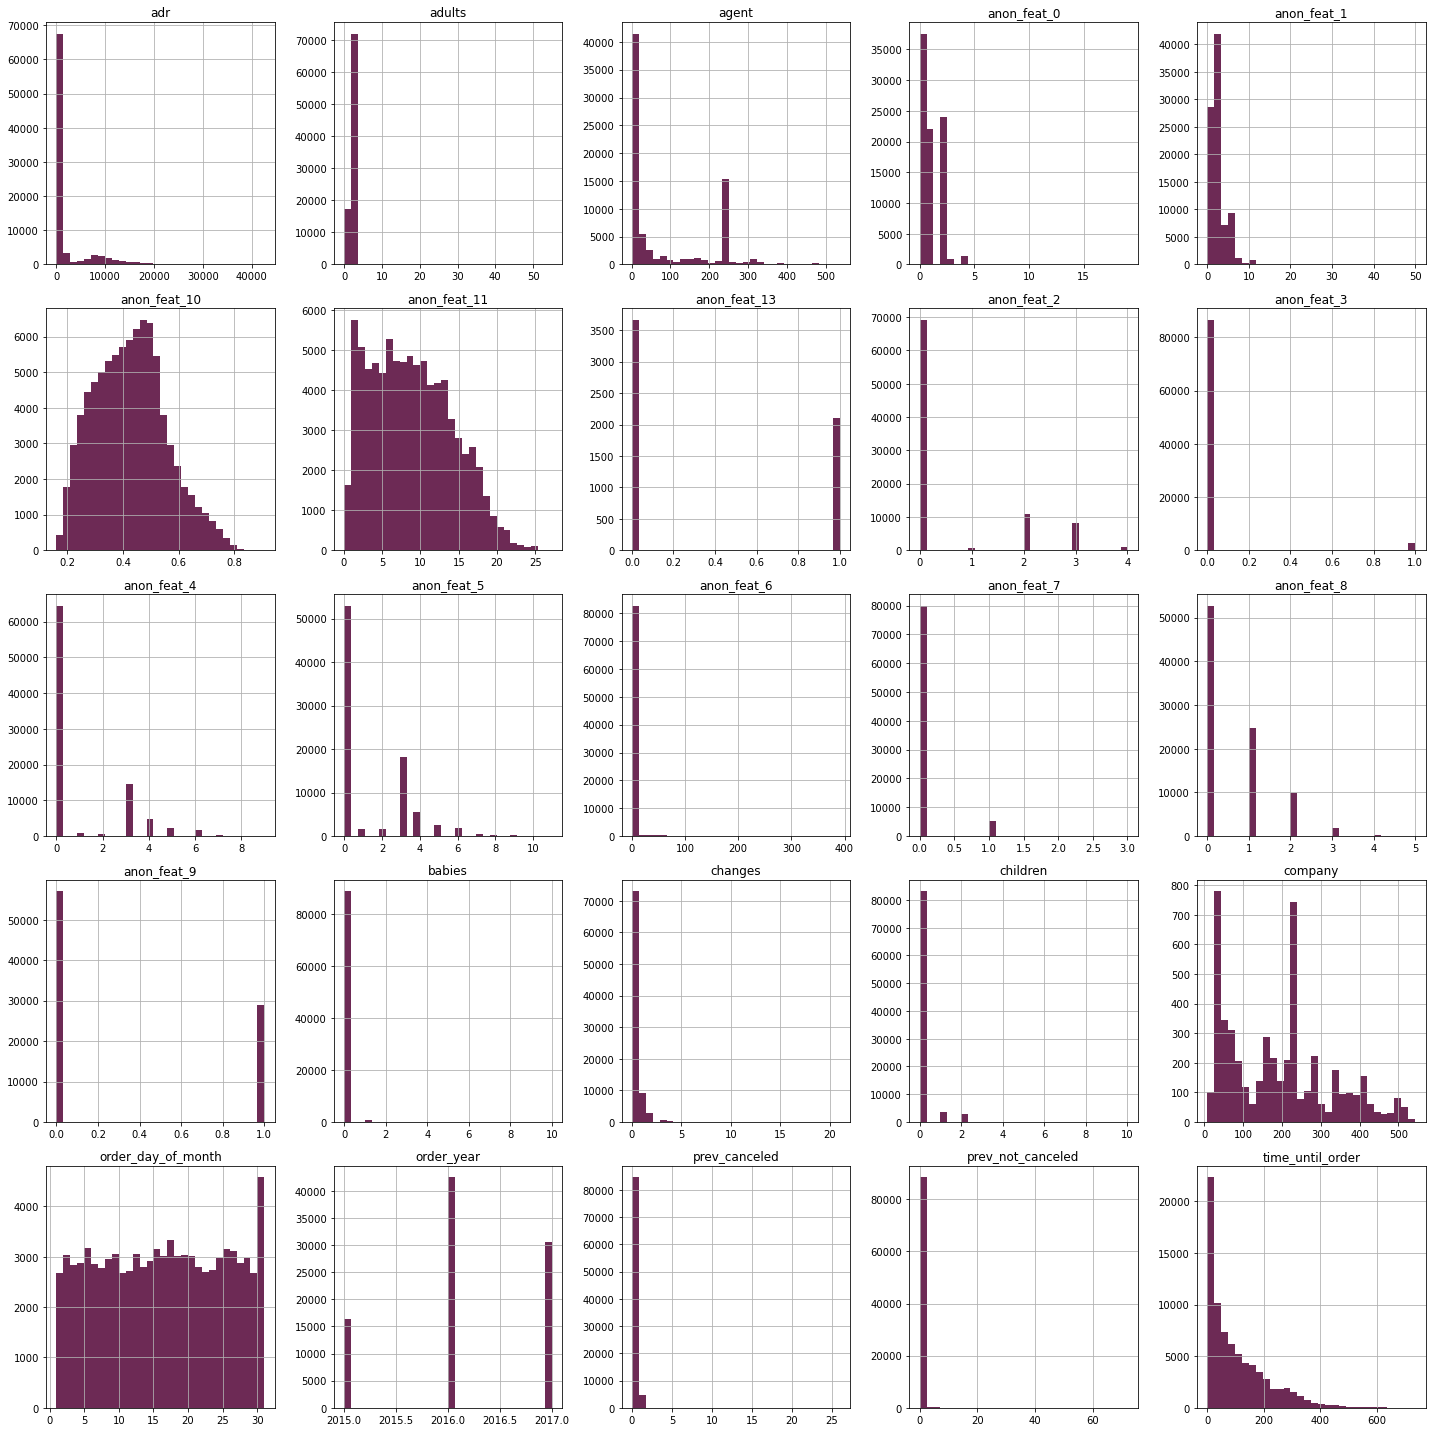

In [13]:
numerical_features.hist(figsize=(20,20), color = '#6d2a55',bins=30)
plt.tight_layout()
plt.show()

From observation of this histogram we can notice some things:

##### Insights on Data Distribution

- These features have very different scales.
- Many histograms are tail heavy. This may make it a bit harder for some algorithms to detect patterns. 

    - We will deal with it in the data transformation section.

##### Insights into the meaning of data
- According to the time until order we can see that most pepople booking shortly before the arrival.
- According to babies and children histogram, most people don't bring their kids, which possibly means that they have a business purpose or they a couple who are on a honeymoon.
- Most people don't make changes in their orders
- Most of the orders were on 2016, but it's probably because the data only starts from mid-2015 and ends in mid-2017.

In [15]:
numerical_features['order_year'].value_counts()

2016    42501
2017    30579
2015    16462
Name: order_year, dtype: int64

- The data is only from 2015 to 2017 and we can treat it as categorical feature so we will remove it from the numerical features list and add it to the categorical list later.

In [16]:
numerical_features.pop('order_year');

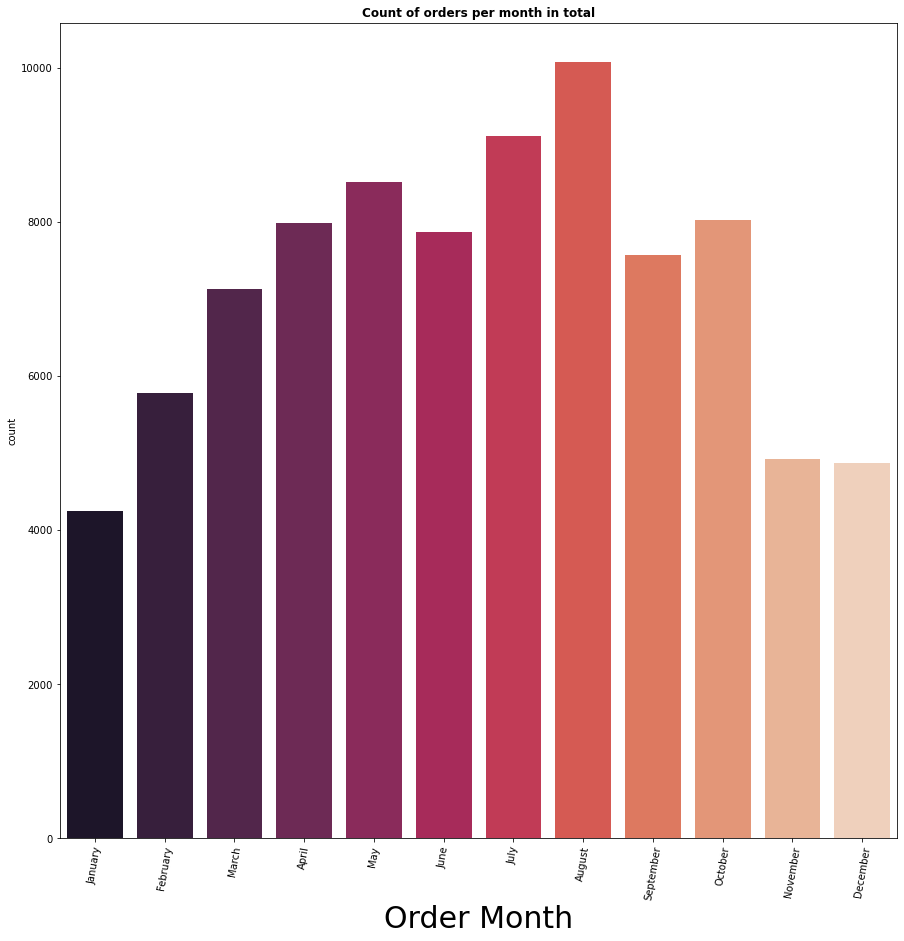

In [18]:
## Reorder the months for better visualization
Month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Check the total demand per month between 2015-2017
plt.figure(figsize=(15,15))
sns.countplot(df['order_month'], palette='rocket', order = Month)
plt.title('Count of orders per month in total', weight='bold')
plt.xticks(rotation = 80)
plt.xlabel('Order Month', fontsize=30)
plt.show()

- As we can see, the Summer months, May-August, have the highest demand and the Winter months, November and December have the lowest damand.

#### Focusing on cancelation

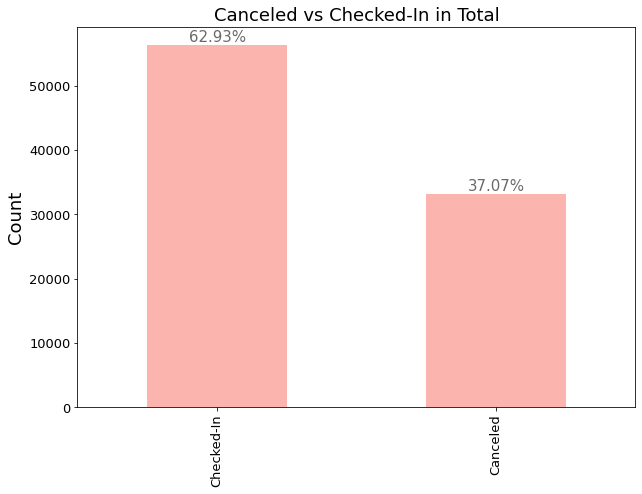

In [19]:
ax = df['cancelation'].value_counts().plot(kind='bar', figsize=(10,7),
                                        color="#fbb4ae", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Canceled vs Checked-In in Total", fontsize=18)
plt.xticks([0,1],['Checked-In', 'Canceled'])
ax.set_ylabel("Count", fontsize=18);

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey', ha='left', va='bottom')

- Only 37% orders in this data were canceled. This may indicate unbalanced data.

Text(0, 0.5, 'ADR')

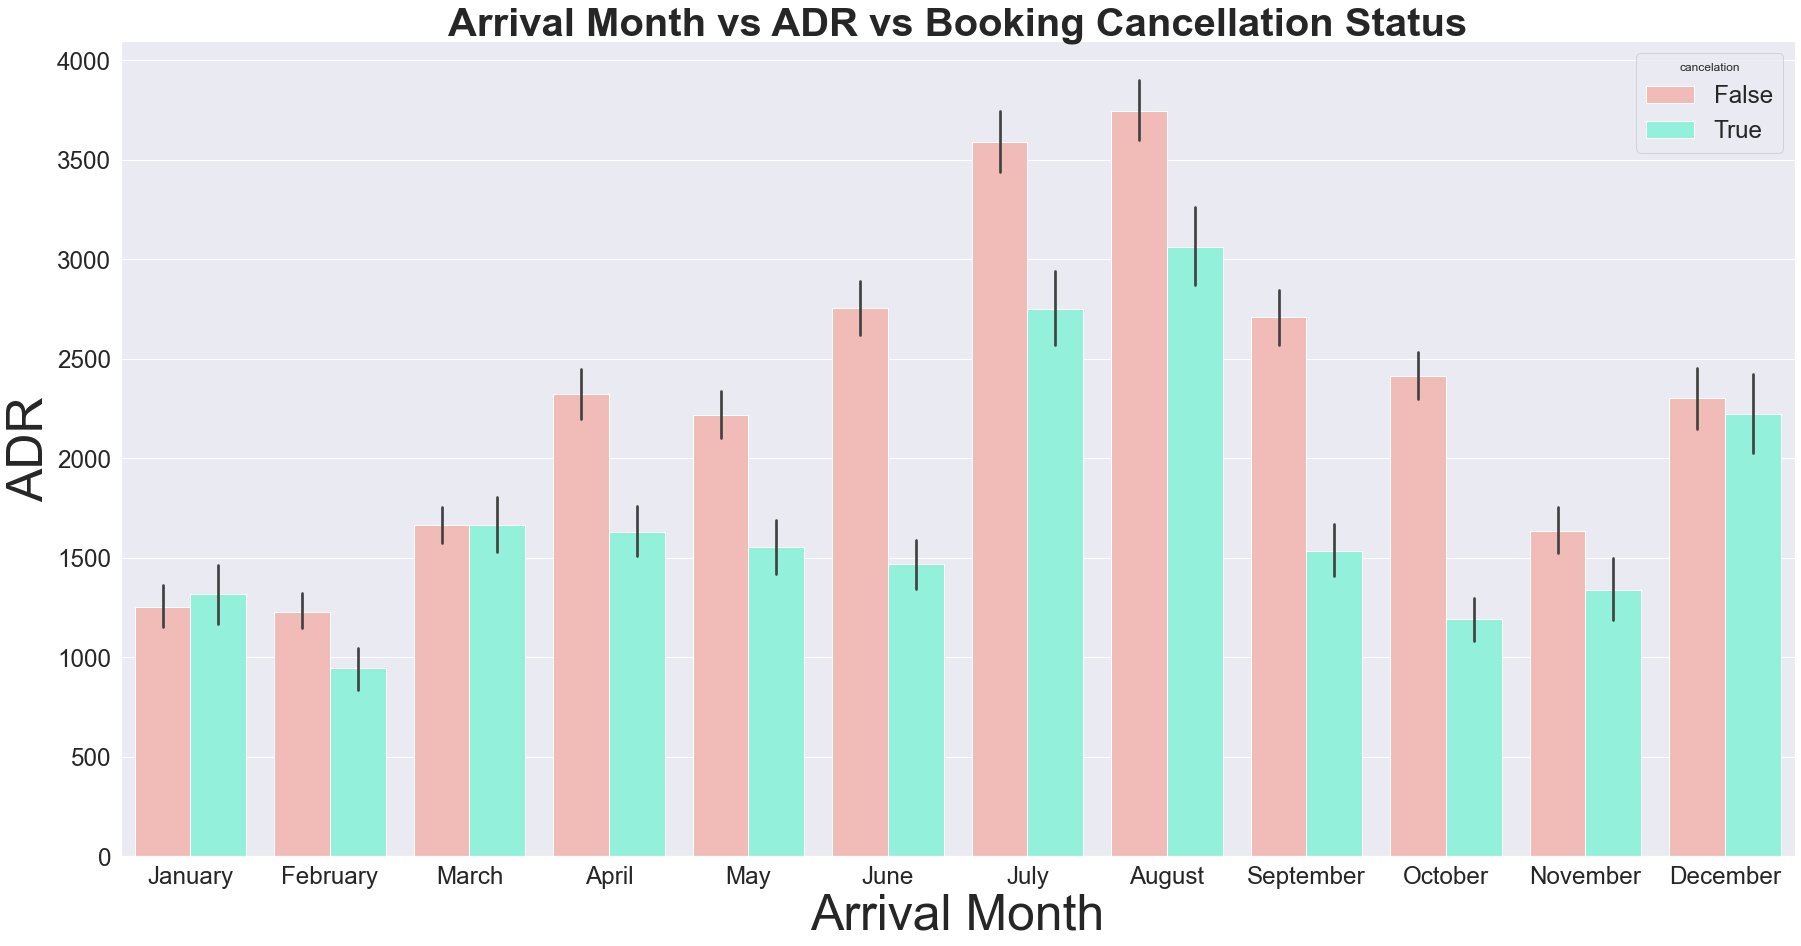

In [21]:
# Display `ADR` vs `Booking Cancellation Status` by month
df_eda = df.copy()
df_eda['adr'] = df_eda['adr'].astype(float)
plt.figure(figsize=(30,15))
sns.barplot(x='order_month', y='adr', hue='cancelation', dodge=True, palette= sns.color_palette(['#fbb4ae', '#84ffe3']), data=df_eda, order=Month)
sns.set(font_scale = 2.2)
plt.title('Arrival Month vs ADR vs Booking Cancellation Status', weight='bold', size=40)
plt.xlabel('Arrival Month', fontsize=50)
plt.ylabel('ADR', fontsize=50)

- August is the busiest month both in terms of number of arrivals and in terms of the number of bookings made.

- Notice that in the months of July, August and September, cancelled bookings have higher number of ADR than those that weren’t cancelled.

#### Exploring outliers

In [23]:
numerical_features.describe().T

count         mean          std       min        25%  \
time_until_order    76861.0   103.673879   106.940156  0.000000  18.000000   
order_day_of_month  89542.0    15.828807     8.779753  1.000000   8.000000   
adults              89542.0     1.857497     0.565296  0.000000   2.000000   
children            89538.0     0.103732     0.397797  0.000000   0.000000   
babies              89542.0     0.007896     0.095194  0.000000   0.000000   
prev_canceled       89542.0     0.087411     0.849799  0.000000   0.000000   
prev_not_canceled   89542.0     0.137701     1.496269  0.000000   0.000000   
changes             86065.0     0.223877     0.663361  0.000000   0.000000   
agent               77346.0    86.731647   110.808075  1.000000   9.000000   
company              5062.0   189.097787   130.799729  8.000000  67.000000   
adr                 86559.0  2218.095784  4421.170623  0.000000  84.000000   
anon_feat_0         86161.0     0.928587     1.001297  0.000000   0.000000   
anon_feat_1         89542.0     2.500972     1.919161  0.000000   1.000000   
anon_feat_2         89542.0     0.556901     1.069291  0.000000   0.000000   
anon_feat_3         89542.0     0.032231     0.176613  0.000000   0.000000   
anon_feat_4         89542.0     0.989971     1.698086  0.000000   0.000000   
anon_feat_5         85510.0     1.330944     1.879927  0.000000   0.000000   
anon_feat_6         85309.0     2.339401    17.516854  0.000000   0.000000   
anon_feat_7         85294.0     0.062607     0.243415  0.000000   0.000000   
anon_feat_8         89542.0     0.571922     0.793567  0.000000   0.000000   
anon_feat_9         85811.0     0.335691     0.472234  0.000000   0.000000   
anon_feat_10        86810.0     0.427146     0.128140  0.161008   0.328012   
anon_feat_11        84585.0     8.845679     5.236673  0.038632   4.452191   
anon_feat_13         5776.0     0.365132     0.481509  0.000000   0.000000   

                           50%          75%           max  
time_until_order     69.000000   159.000000    737.000000  
order_day_of_month   16.000000    23.000000     31.000000  
adults                2.000000     2.000000     55.000000  
children              0.000000     0.000000     10.000000  
babies                0.000000     0.000000     10.000000  
prev_canceled         0.000000     0.000000     26.000000  
prev_not_canceled     0.000000     0.000000     72.000000  
changes               0.000000     0.000000     21.000000  
agent                14.000000   229.000000    535.000000  
company             179.000000   270.000000    543.000000  
adr                 149.000000  1241.000000  42625.000000  
anon_feat_0           1.000000     2.000000     19.000000  
anon_feat_1           2.000000     3.000000     50.000000  
anon_feat_2           0.000000     0.000000      4.000000  
anon_feat_3           0.000000     0.000000      1.000000  
anon_feat_4           0.000000     3.000000      9.000000  
anon_feat_5           0.000000     3.000000     11.000000  
anon_feat_6           0.000000     0.000000    391.000000  
anon_feat_7           0.000000     0.000000      3.000000  
anon_feat_8           0.000000     1.000000      5.000000  
anon_feat_9           0.000000     1.000000      1.000000  
anon_feat_10          0.425622     0.511077      0.907525  
anon_feat_11          8.422255    12.712815     27.172399  
anon_feat_13          0.000000     1.000000      1.000000

- <u> By comparing the mean, min, max values, we suspect that the following features might have outliers: </u>
    - time_until_order, adults, children, babies, prev_canceled, prev_not_canceled, changes, adr, anon_feat_0, anon_feat_1, anon_feat_4, anon_feat_5, anon_feat_6, anon_feat_11

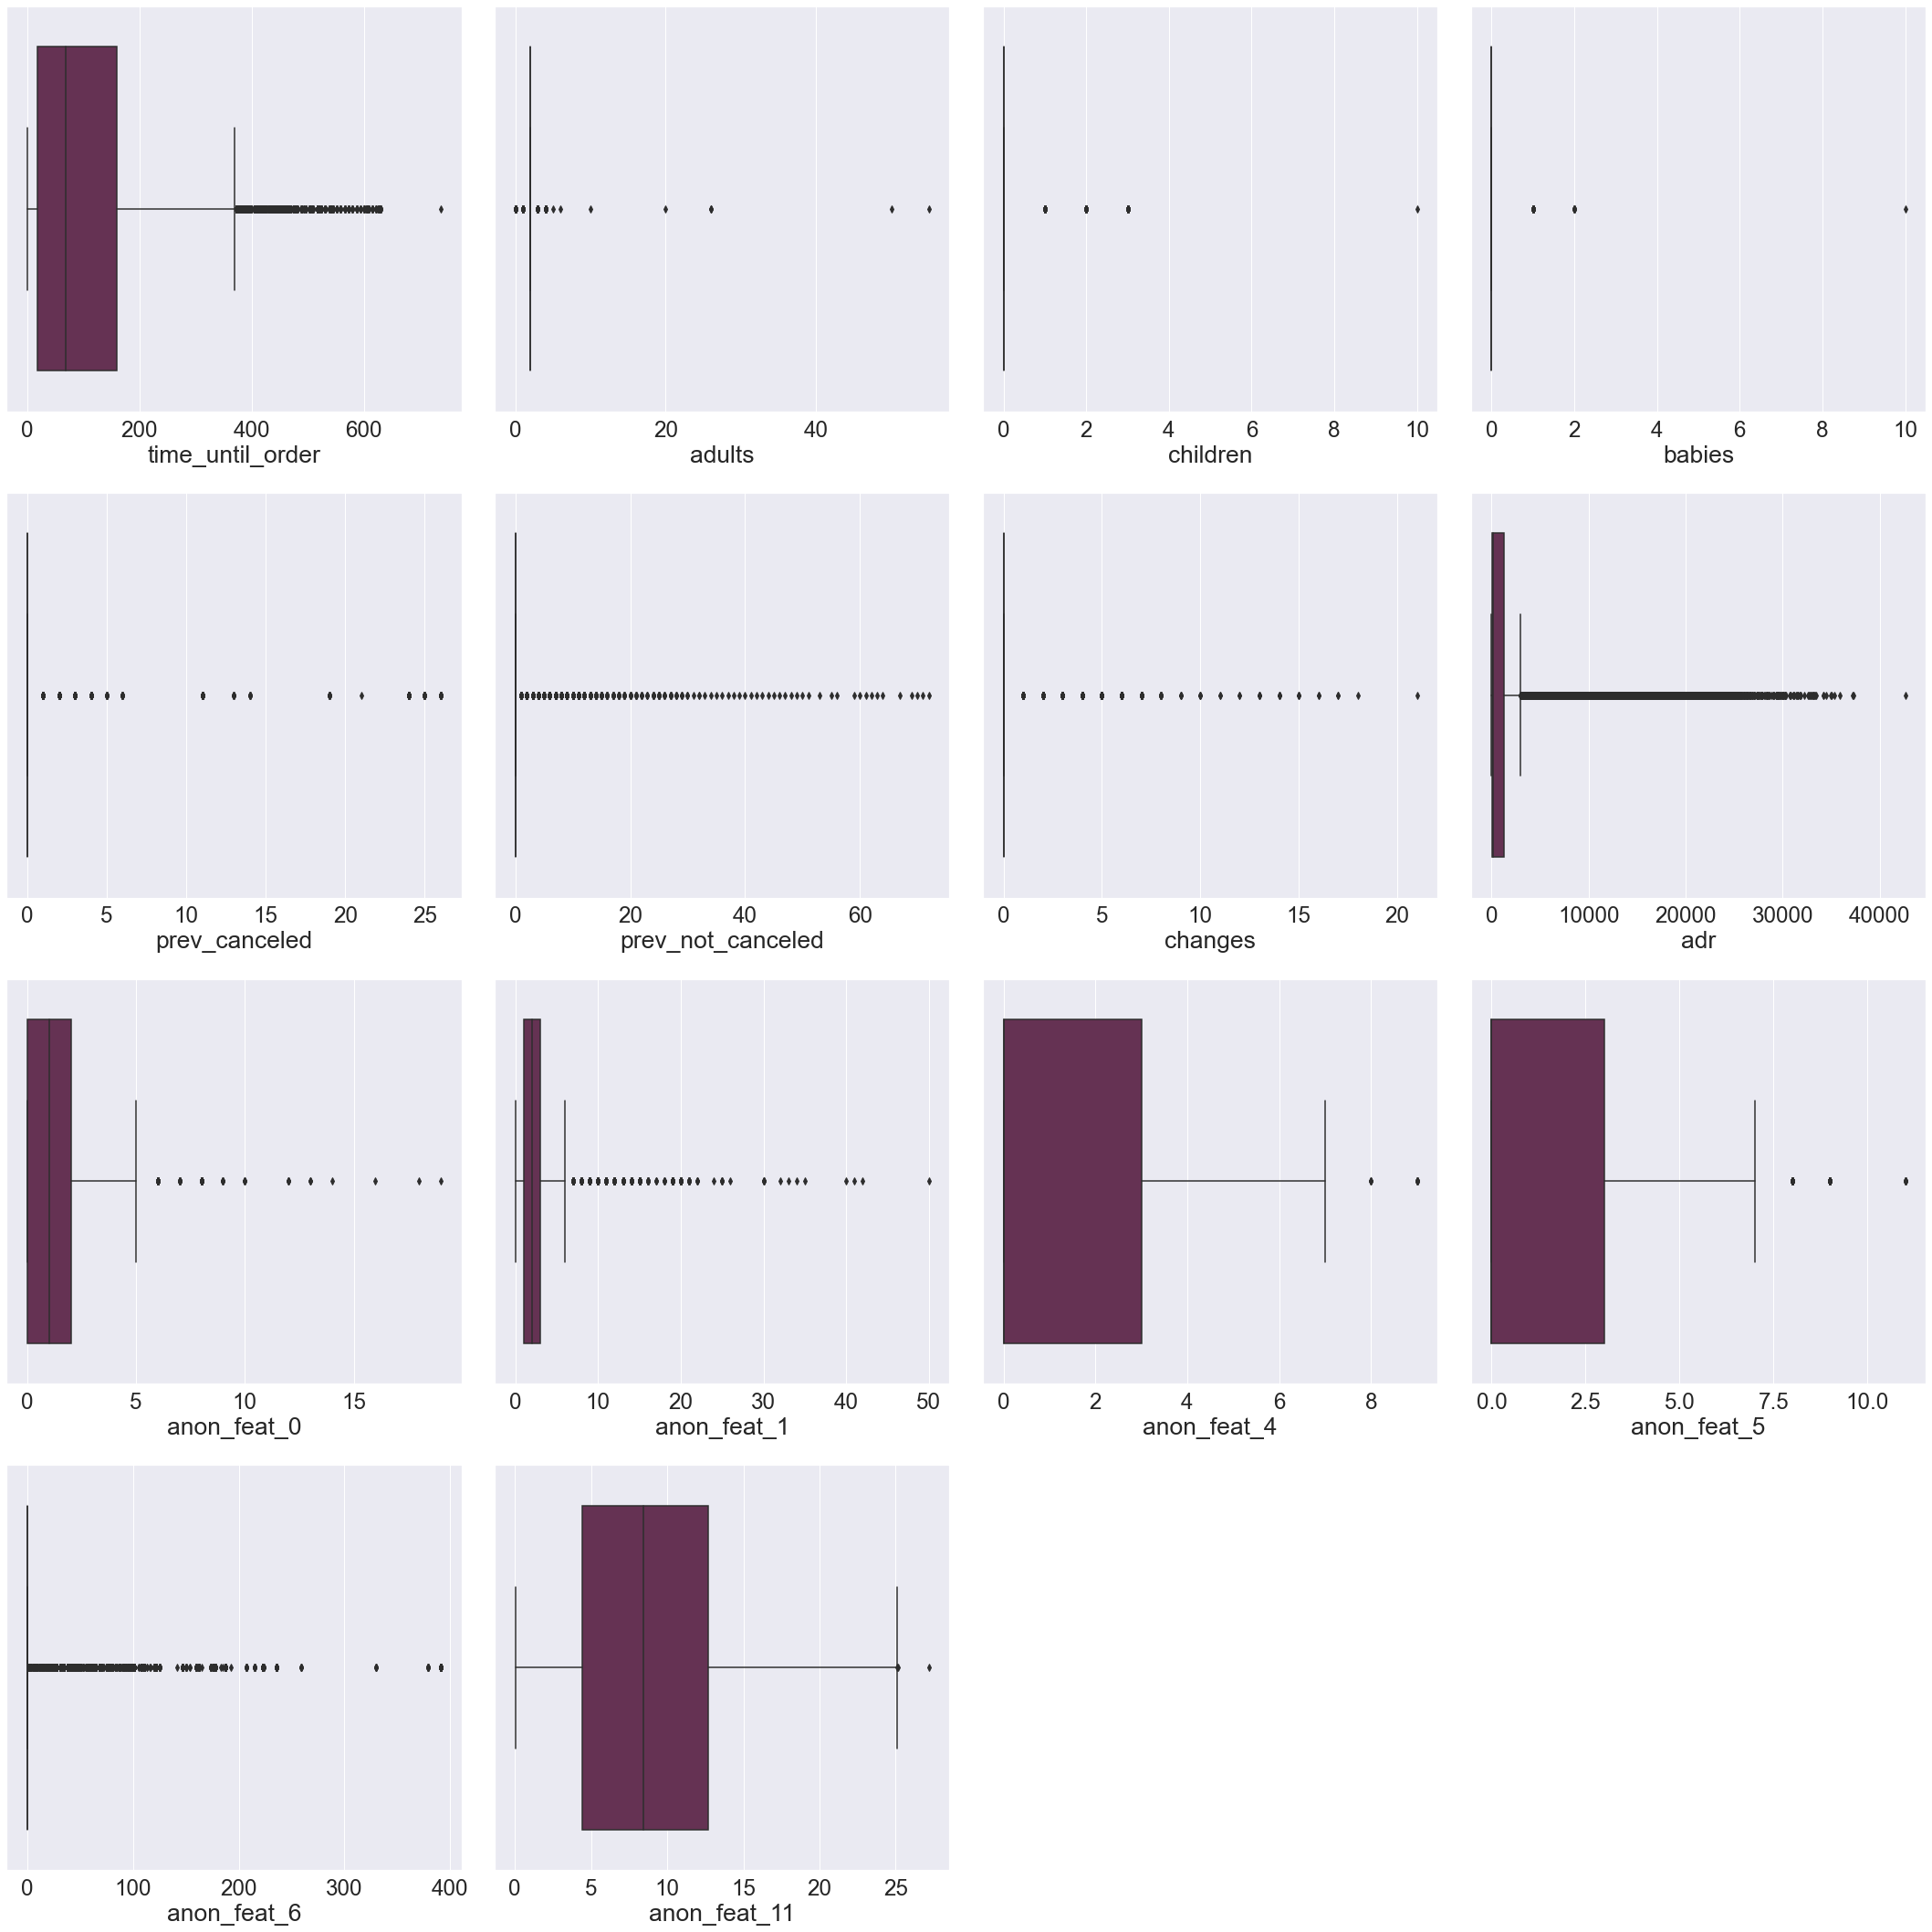

In [24]:
outliers = ['time_until_order', 'adults', 'children', 'babies', 'prev_canceled', 'prev_not_canceled', 'changes', 'adr', 'anon_feat_0', 'anon_feat_1', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6', 'anon_feat_11']
n = 1
plt.figure(figsize=(30,30))

for column in outliers:
  plt.subplot(4,4,n)
  n = n+1
  sns.boxplot(df[column], color = '#6d2a55')
  plt.tight_layout()

- From the graphs we can see that our suspicion is justified and therefore we will address those feature's outliers later in preprocessing section.

#### Correlation check

Text(0.5, 1.0, 'Correlation Matrix')

<Figure size 4320x2880 with 0 Axes>

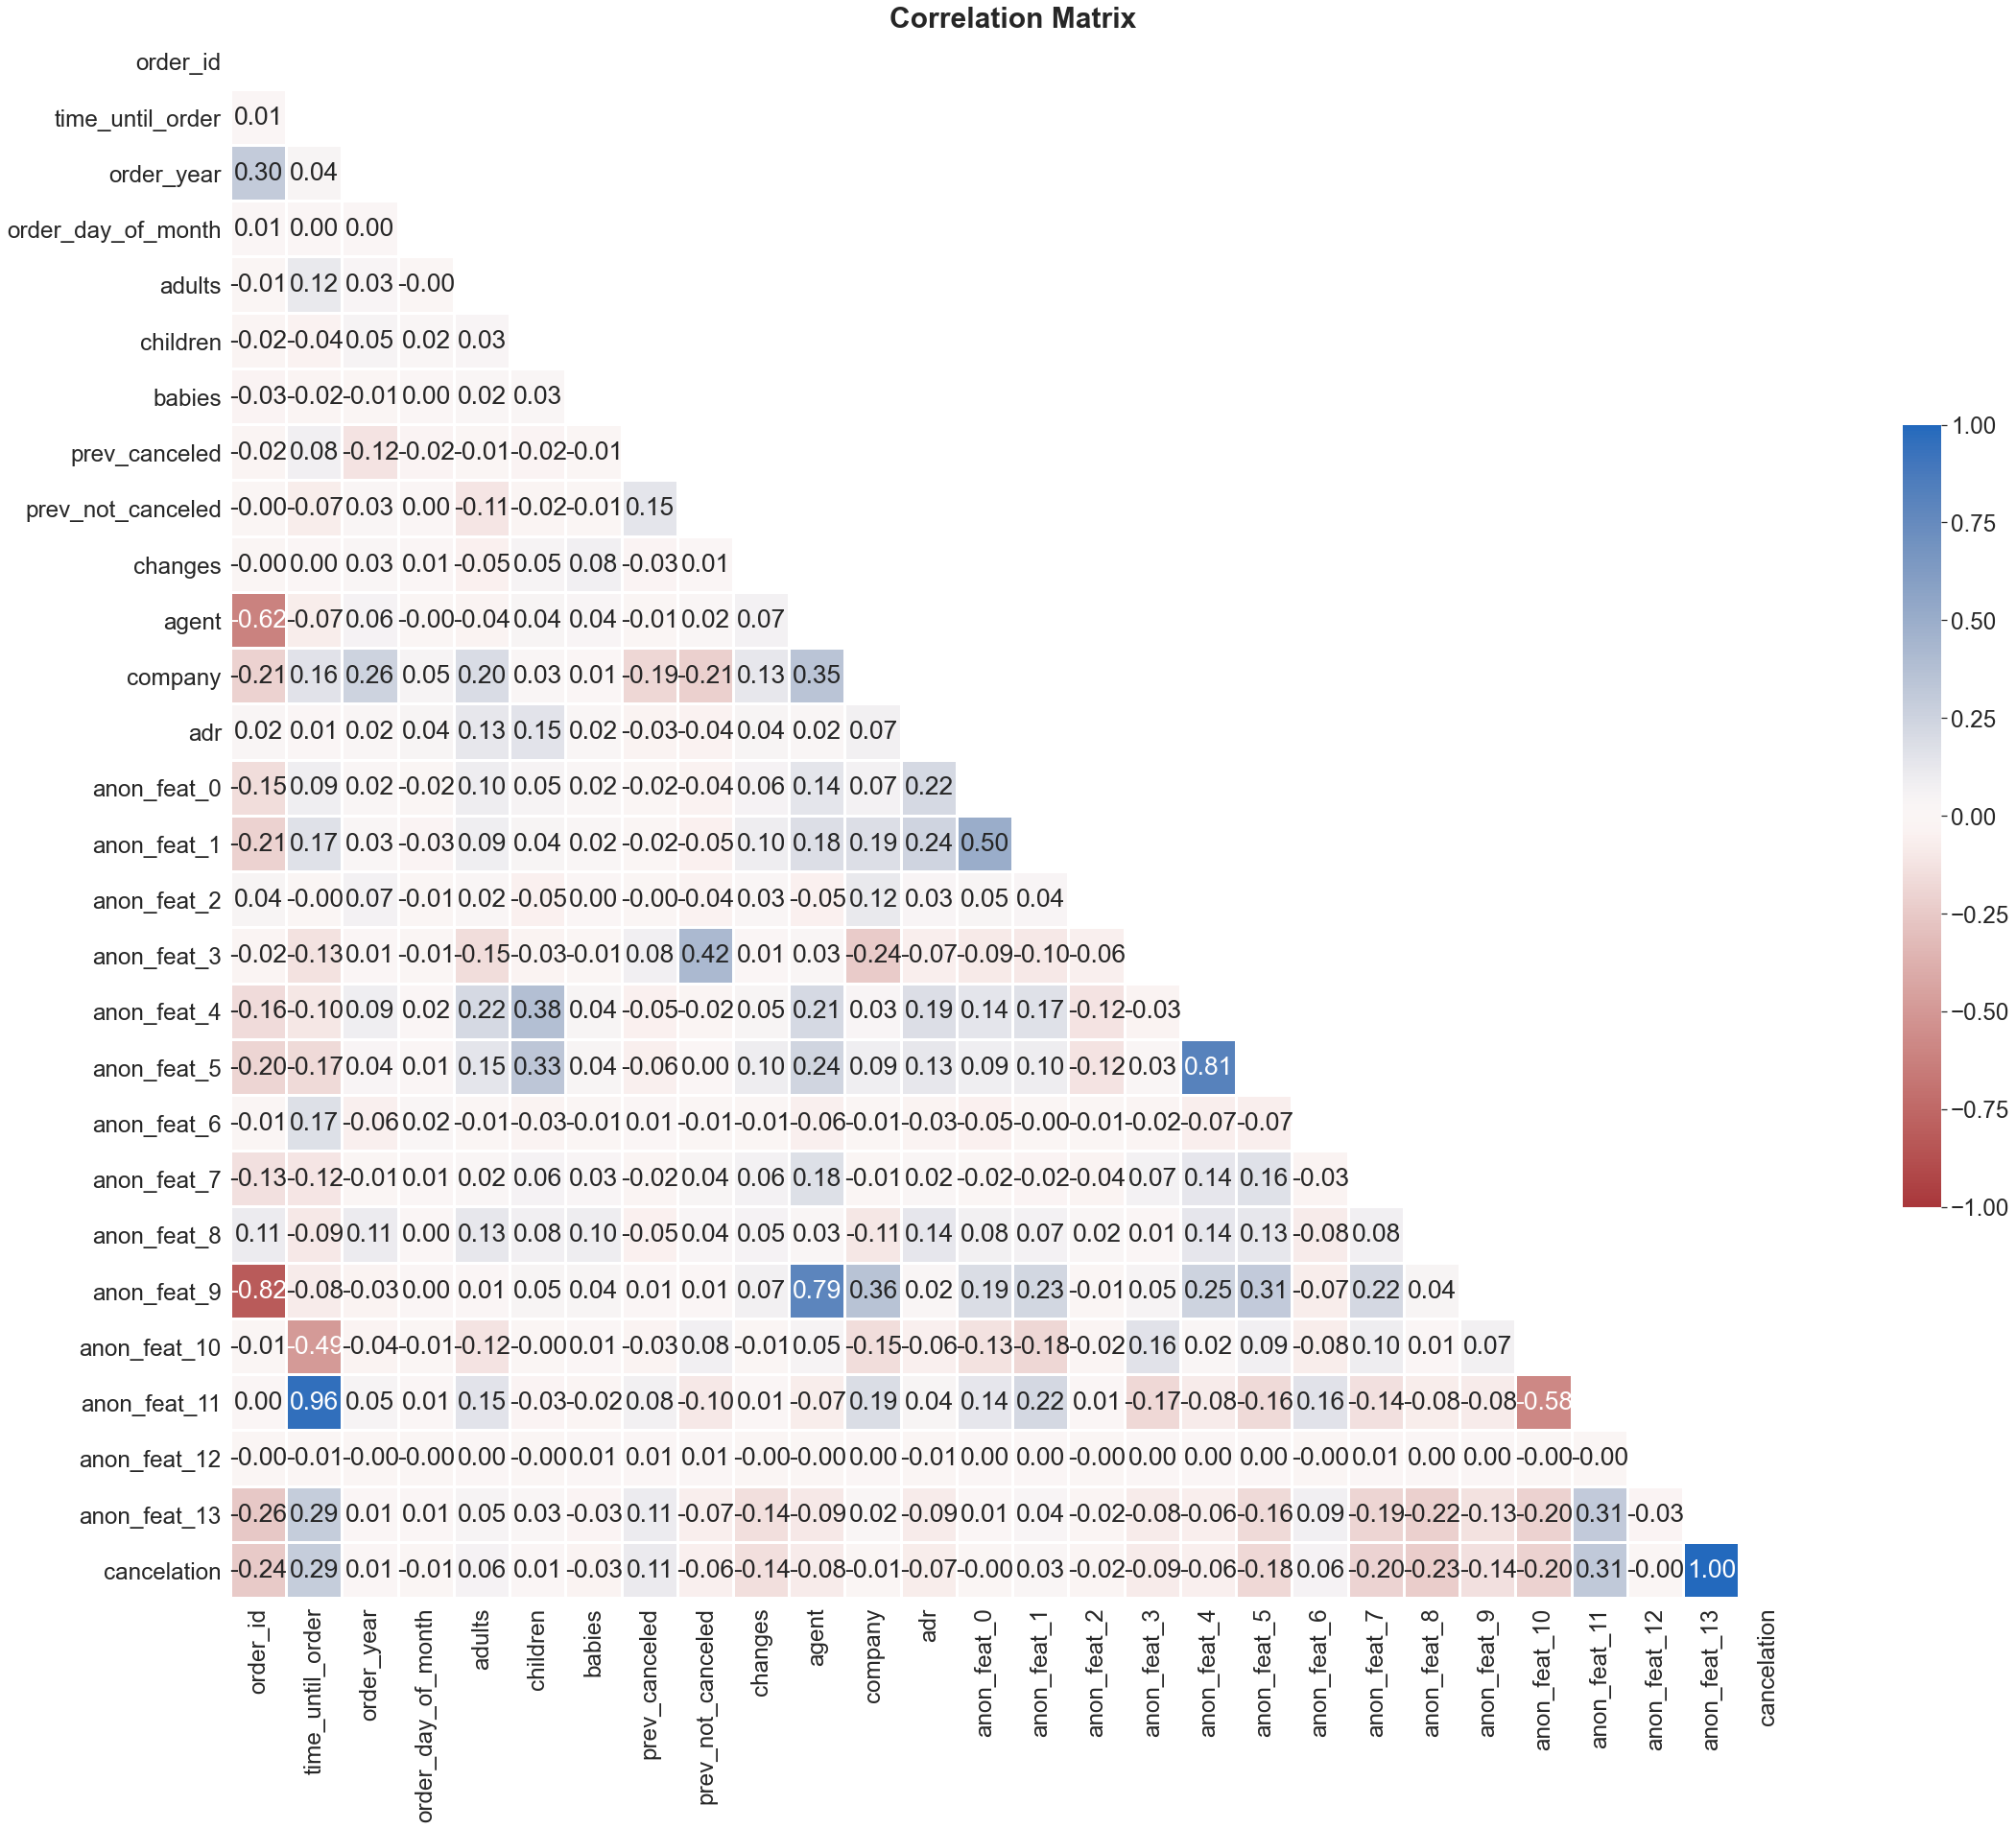

In [25]:
fig = plt.figure(figsize=(60,40))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(40, 30))
    ax = sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap='vlag_r', mask=mask, vmin=-1, vmax= 1,center= 0, square=True,linewidths=2, cbar_kws={"shrink": .5})

sns.set(font_scale = 3)
plt.title("Correlation Matrix",size=30, weight='bold')

 - From the matrix we can cunclude that the folllowing features have high correlation:
        - time_until_order and anon_feat_11 
        - cancelation and anon_feat_13
        - anon_feat_9 and order_id
        - anon_feat_9 and agent
        - anon_feat_4 and anon_feat_5

### Categorical features exploration 

In [26]:
categorical_features = df.select_dtypes(include=np.object)
categorical_features['order_year'] = df['order_year']

print("The categorical features are: \n", categorical_features.columns)

The categorical features are: 
 Index(['order_month', 'order_week', 'country', 'order_type',
       'acquisition_channel', 'deposit_type', 'customer_type', 'order_year'],
      dtype='object')


In [27]:
df.describe(include=np.object)

order_month order_week country order_type acquisition_channel  \
count        86108      89542   85201      89542               89542   
unique          12         53     163          8                   5   
top         August    week_33     PRT  Online TA               TA/TO   
freq         10080       2703   34804      42450               73393   

       deposit_type customer_type  
count         80536         79647  
unique            3             4  
top      No Deposit     Transient  
freq          70547         59979

 - We can see that the most frequent order type, is Online TA and the most frequent month is August, the frequent country is Portugal and so on..

A view on the categorical distribution and the top 10 attributes for every feature:

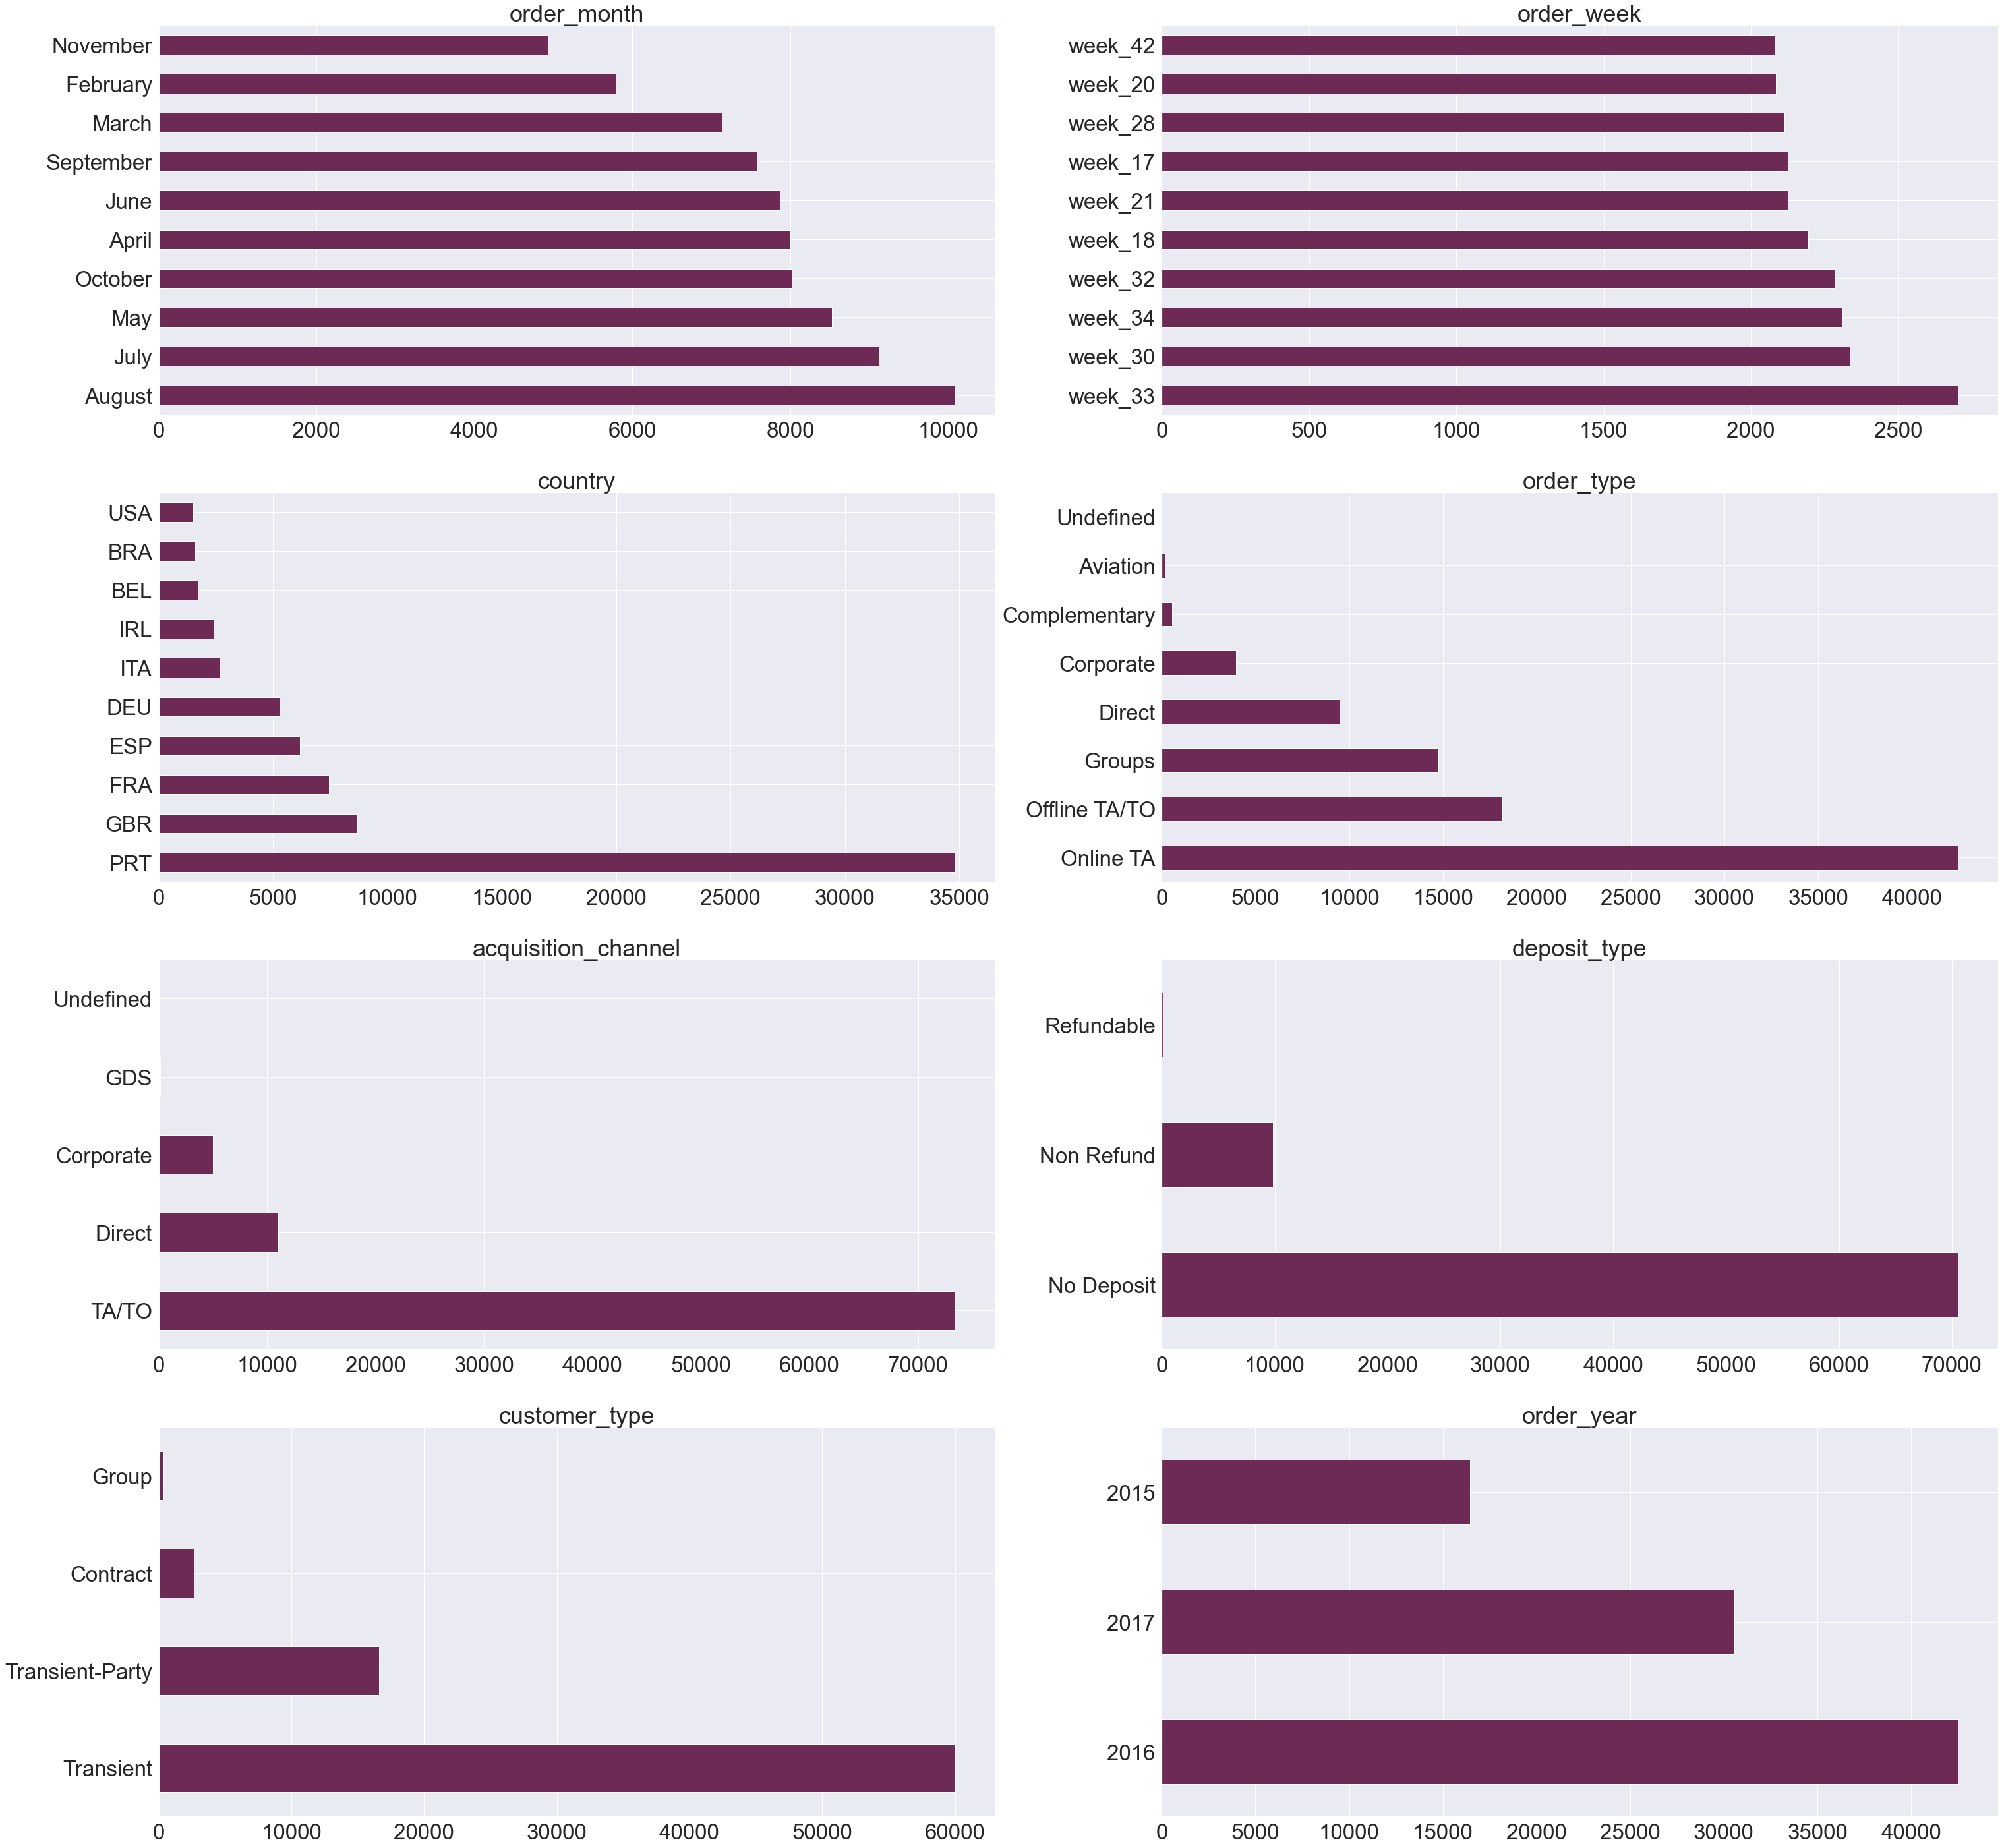

In [28]:
fig = plt.figure(figsize = (50,50))
for i, category in enumerate(categorical_features):
        ax = fig.add_subplot(4,2,i+1)
        ax = df[category].value_counts().head(10).plot.barh(color = '#6d2a55')
        ax.set_title(category)

- Approximately 40% of all bookings were made from one country: Portugal.
- order type and aquisition channel have very similar categories and maybe they indicate on the same inforamtion. Also, they have some Undefiend values that we will remove later.
- We think that order month and order week might give us the same information so maybe will remove one of them.

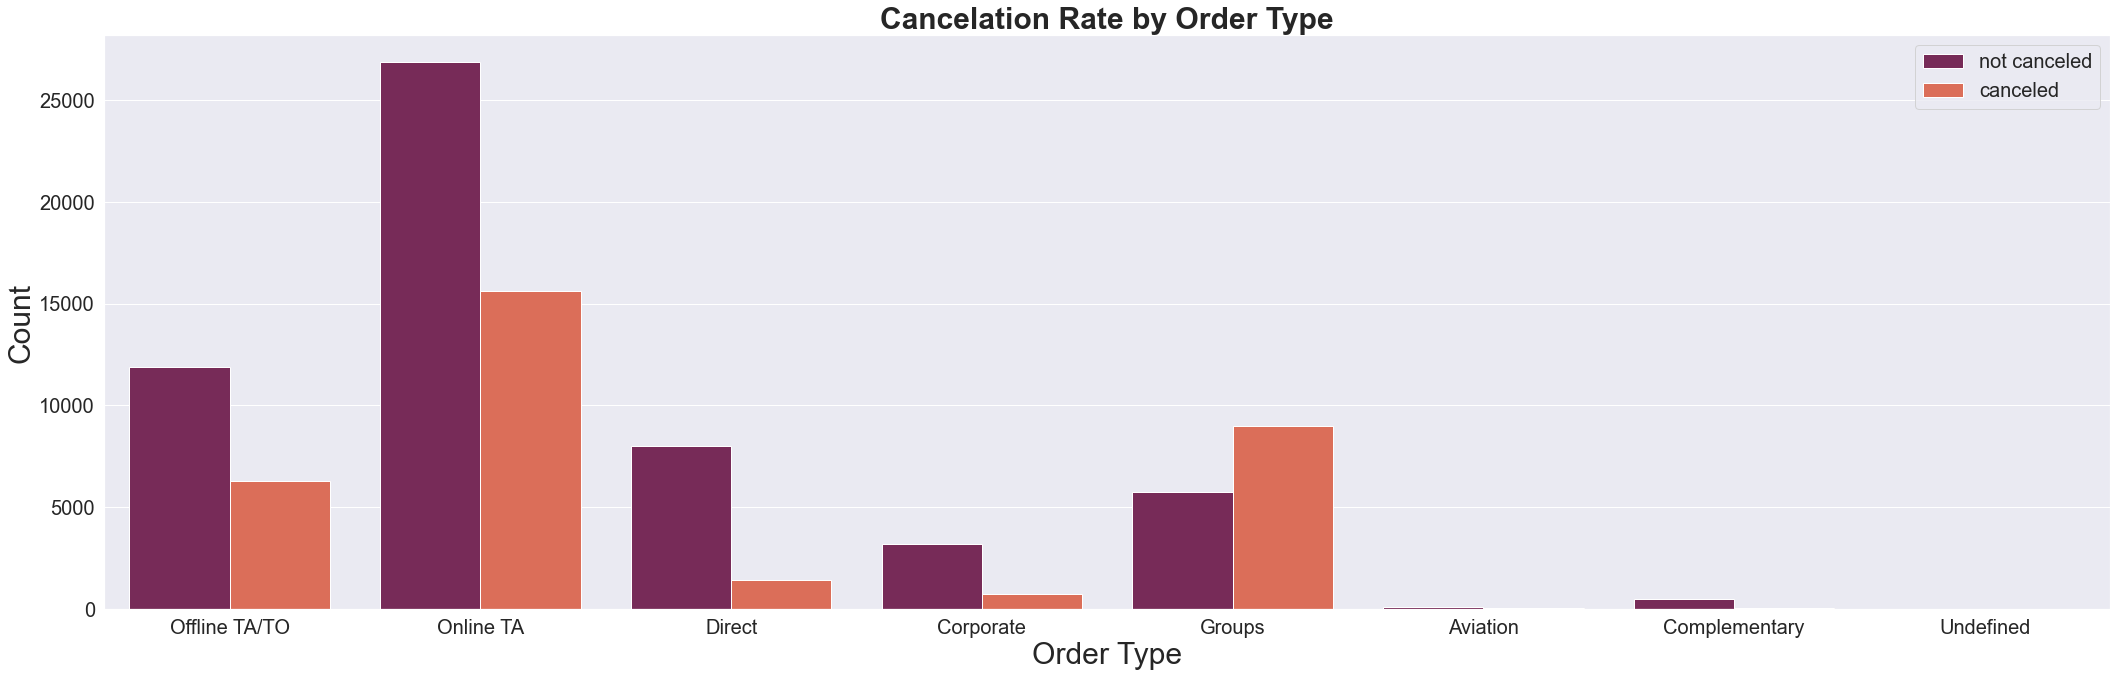

In [22]:
plt.figure(figsize=(30,10))
sns.countplot(x=df_eda["order_type"], hue=df_eda["cancelation"], palette='rocket')
plt.title("Cancelation Rate by Order Type", size=30, weight='bold')
plt.xlabel("Order Type", size=30)
plt.ylabel("Count", size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(["not canceled", "canceled"], loc='upper right',fontsize=20)
plt.tight_layout()
plt.show()

 We can see that: 
 - Most common way of ordering is Online TA.
 - Groups ordering tend to be canceled significally more then other ordering ways.
 - Direct and corporate orders are less canceled. 

#### The ratio between the number of bookings and the number of cancellations in each country

In [30]:
## Count how many visitors from each country made booking and how many canceled it
total_booking = df_eda['country'].value_counts()
data_canceled = df_eda.loc[df_eda['cancelation'] == True, 'country'].value_counts()
cancelation_ratio = data_canceled.divide(total_booking, fill_value=0)

## Use dict to cast the list into a dictionary
data_r = dict( 
        autocolorscale=False,
        colorscale = 'Pinkyl',
        type = 'choropleth',
        locations = cancelation_ratio.index,
        z = cancelation_ratio
      )

## Create a layout object
layout_r = dict( 
    title = 'The ratio between the number of bookings and the number of cancellations in each country',
    geo = dict(
        showframe = False,
        projection = dict(type = 'orthographic')
    )
)
## Display of the World Visitors Choromap
fig_r = go.Figure(data = [data_r],layout = layout_r)
fig_r.update_geos( resolution=50,
    showocean=True, oceancolor="LightBlue",
    )
iplot(fig_r)

- From this map we can see the ratio between the total number of bookings and the number of cancellations for each country that was in the data.
- It can be seen that there are countries that maybe are more likely to cancel the bookings.

# Pre-processing 

#### Cleaning missing values

In [31]:
#check for missing values
df.isnull().mean()*100

order_id                0.000000
time_until_order       14.162069
order_year              0.000000
order_month             3.835072
order_week              0.000000
order_day_of_month      0.000000
adults                  0.000000
children                0.004467
babies                  0.000000
country                 4.848004
order_type              0.000000
acquisition_channel     0.000000
prev_canceled           0.000000
prev_not_canceled       0.000000
changes                 3.883094
deposit_type           10.057850
agent                  13.620424
company                94.346787
customer_type          11.050680
adr                     3.331398
anon_feat_0             3.775882
anon_feat_1             0.000000
anon_feat_2             0.000000
anon_feat_3             0.000000
anon_feat_4             0.000000
anon_feat_5             4.502915
anon_feat_6             4.727390
anon_feat_7             4.744142
anon_feat_8             0.000000
anon_feat_9             4.166760
anon_feat_

#### Drop features

- Some of the features have a high percentage of missing values, we cannot fill them with other values as this would be too crude an intervention on our part that might skew the data. Thus, we decided to drop them.

In [32]:
df = df.drop(['anon_feat_13', 'company'],axis=1)
numerical_features = numerical_features.drop(['anon_feat_13', 'company'], axis=1)

- The feature 'order_month' has missing values but the feature 'order_week' does not. Since it is possible to understand by the number of the week which month is it, we will drop the 'order_month' feature.

In [33]:
df = df.drop('order_month',axis=1)
categorical_features = categorical_features.drop(['order_month'],axis=1)

In [34]:
X, y = df.drop(columns = 'cancelation'), df.cancelation

# Split to train and validation data sets, random state is set so we could produce the same data sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                test_size = 0.2, 
                                                                random_state = 42)

In [35]:
# A copy for the pre_processing_func (a funtction of pre_processing for the validaition and test sets)
X_train_copy = X_train.copy()

- Before Pre-processing we would like to check the label distribution of the train and the test:

In [36]:
y_train.value_counts()/len(y_train)

False    0.630129
True     0.369871
Name: cancelation, dtype: float64

In [37]:
y_validation.value_counts()/len(y_validation)

False    0.625831
True     0.374169
Name: cancelation, dtype: float64

- We can see that the label distribution of the train and the test are very similar.  

#### Fill NA

- For continuous and skewed features (numerical) we will use median to replace the missing values.
- For features with a discrete distribution (numerical and categorical) we will use the most frequent value (mode) to replace the missing values.

In [38]:
median_fill_features = df[['adr','anon_feat_0','anon_feat_5','anon_feat_6','children','changes',
                           'time_until_order','anon_feat_10','anon_feat_11']]

mode_fill_features = df[['anon_feat_7','anon_feat_9','agent','country','deposit_type','customer_type']]

In [39]:
for col in median_fill_features:
    med = X_train[col].median()
    X_train[col] = X_train[col].fillna(med)
       
for col in mode_fill_features:
    mode = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode)
    
#check for missing values
X_train.isnull().mean()*100

order_id               0.0
time_until_order       0.0
order_year             0.0
order_week             0.0
order_day_of_month     0.0
adults                 0.0
children               0.0
babies                 0.0
country                0.0
order_type             0.0
acquisition_channel    0.0
prev_canceled          0.0
prev_not_canceled      0.0
changes                0.0
deposit_type           0.0
agent                  0.0
customer_type          0.0
adr                    0.0
anon_feat_0            0.0
anon_feat_1            0.0
anon_feat_2            0.0
anon_feat_3            0.0
anon_feat_4            0.0
anon_feat_5            0.0
anon_feat_6            0.0
anon_feat_7            0.0
anon_feat_8            0.0
anon_feat_9            0.0
anon_feat_10           0.0
anon_feat_11           0.0
anon_feat_12           0.0
dtype: float64

Replacing undefined values we saw earlier in order_type and acquisition_channel to mode values.

In [40]:
mode = X_train['order_type'].mode()[0]
X_train['order_type'] = X_train['order_type'].apply(lambda x: mode if x == 'Undefined' else x)
    
mode = X_train['acquisition_channel'].mode()[0]
X_train['acquisition_channel'] = X_train['acquisition_channel'].apply(lambda x: mode if x == 'Undefined' else x)

### Dealing with outliers

- As we saw eariler, the data has outliers in some features. As you can see below we made an attempt to remove the outliers from the train set using Z-score method. We saw that even for 5 standard deviations, too much data is removed which resulted in bad model perfermance. Thus, we decided not to remove the outliers and to deal with the skeness of the data distribution with Standardization later. 

In [41]:
# # adding the cancelation feature so the removal will be from both date sets respectively.
# X_train['cancelation'] = y_train
# for col in outliers:
#     mean = X_train[col].mean()
#     std = X_train[col].std(ddof = 0)
    
#     z_scores_train = (X_train[col] - mean)/(std)
#     X_train = X_train[z_scores_train < 5]
    
# # returning to the original splited data sets  
# X_train, y_train = X_train.drop(columns = 'cancelation'), X_train.cancelation
# X_train.shape

## Pre-process the categorical features

- removing the 'week_' string from the 'order_week' values and converting the number to int. 

In [42]:
X_train['order_week'] = X_train['order_week'].apply(lambda x: x[5:])
X_train['order_week'] = pd.to_numeric(X_train['order_week'])

### Creating new features

 - Creating 'season' feature from 'order_week' by week numbers.

In [43]:
def order_week_to_season(row):
    if (row['order_week'] > 0 and row['order_week'] <= 9) or (row['order_week'] > 48 and row['order_week'] <= 53):
        return 'Winter'
    if (row['order_week'] > 9 and row['order_week'] <= 21):
        return 'Spring'
    if (row['order_week'] > 21 and row['order_week'] <= 34):
        return 'Summer'
    if (row['order_week'] > 34 and row['order_week'] <= 48):
        return 'Fall'

X_train['season'] = X_train.apply(lambda row : order_week_to_season(row), axis=1)

 - Creating 'time_in_month' feature from 'order_day_of_month' according to month days.

In [44]:
time_in_month = pd.cut(X_train["order_day_of_month"],
        bins=[0, 10, 20 ,31], 
        labels=['Begining', "Middle", "End"])
X_train['time_in_month'] = time_in_month

- Changing the 'country' column to binary, by classifying it according to their presence in the top ten most common countries.

In [45]:
top_ten_countries = pd.value_counts(X_train['country']).iloc[:10].index
X_train['is_in_top_ten_countries'] = X_train.country.isin(top_ten_countries) == 1

- Creating new feature called 'num_of_guests' by combining adults and children. The reason for it is that most of the children values are zeros.

In [46]:
X_train['num_of_guests'] = X_train['adults'] + X_train['children'] + X_train['babies']

- Creating new feature called 'cancellation_rate' that will indicate if the customer is a frequent canceller.

In [47]:
X_train.loc[:, 'cancellation_rate'] = (X_train['prev_canceled'] / (X_train['prev_canceled'] + X_train['prev_not_canceled'])).copy()
X_train.loc[:, 'cancellation_rate'].fillna(-1, inplace=True)
X_train.head()

order_id  time_until_order  order_year  order_week  order_day_of_month  \
51499     50201              84.0        2016          18                  25   
24645     19744              69.0        2015          53                  30   
42396     27654              61.0        2016          36                   3   
13630     49615              69.0        2016          16                  16   
86613      6029              69.0        2016          21                  21   

       adults  children  babies country order_type  ... anon_feat_8  \
51499       2       0.0       0     PRT     Direct  ...           2   
24645       2       0.0       0     PRT     Groups  ...           0   
42396       2       0.0       0     USA  Online TA  ...           1   
13630       2       0.0       0     FRA  Online TA  ...           0   
86613       2       0.0       0     PRT  Online TA  ...           1   

       anon_feat_9  anon_feat_10  anon_feat_11 anon_feat_12  season  \
51499          0.0      0.521128      9.191250        False  Spring   
24645          1.0      0.387317     10.596134        False  Winter   
42396          1.0      0.285840      7.918835        False    Fall   
13630          0.0      0.488252      8.652006        False  Spring   
86613          1.0      0.398623      9.070482        False  Spring   

      time_in_month  is_in_top_ten_countries  num_of_guests  cancellation_rate  
51499           End                     True            2.0               -1.0  
24645           End                     True            2.0               -1.0  
42396      Begining                     True            2.0               -1.0  
13630        Middle                     True            2.0               -1.0  
86613           End                     True            2.0               -1.0  

[5 rows x 36 columns]

In [48]:
#convert anon_feat_12 from bool to int
X_train["anon_feat_12"] = X_train["anon_feat_12"].astype(int)

In [49]:
#adding the new features
numerical_features['order_week'] = X_train['order_week']
numerical_features['anon_feat_12'] = X_train['anon_feat_12']
numerical_features['num_of_guests'] = X_train['num_of_guests']
numerical_features['cancellation_rate'] = X_train['cancellation_rate']
numerical_features['is_in_top_ten_countries'] = X_train['is_in_top_ten_countries']

## Dimensionality Problem - Part A

- Dimensionality problem occurs when the number of features we use is too large and this may create a problem because some of the calculation algorithms of the models are aided by Euclidean distance calculations. This means that the more dimensions the bigger the distance between samples. Beacuse high dimensional datasets are at risk of being sparsed, the samples will be far away from each other. This can lead to that a new sample can be very far from the training samples, making the predictions less reliable, and in short, can cause overfitting. 
- In this part, we would like to reduce the data's dimension by Feature selection methods. Later we will address the dimensionality problem again and also use PCA.

## Feature selection

#### Checking the correlation between 'order_type' and 'acquisition_channel'

In [50]:
def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]
    contigency = pd.crosstab(df_col1, df_col2)
    c, p, dof, expected = chi2_contingency(contigency)
    if (p < 0.05):
        print('p value is',p,'meaning that we reject the null hypothesis at 95% level of confidence.')
        print('the features',col1,'and',col2,'are dependent, thus we can remove one of them.\n')
    else: 
        print('p value is',p,'meaning that we do not reject the null hypothesis at 95% level of confidence.')
        print('the features',col1,'and',col2,'are independent, thus we can remove one of them.\n')
chi_square_of_df_cols(X_train, 'order_type', 'acquisition_channel')

p value is 0.0 meaning that we reject the null hypothesis at 95% level of confidence.
the features order_type and acquisition_channel are dependent, thus we can remove one of them.



### Correlation check

- This was an attemp to handle the dimensionality problem using only the top ten features that have the highest correlation with the label. We found that this method is too agresive and it caused worse performence.

In [51]:
# X, y = df.drop(columns = 'cancelation'), df.cancelation
# X.corrwith(y).sort_values(ascending=False)
# top_ten_corolation = ['deposit_type','anon_feat_11','prev_canceled','time_until_order','anon_feat_7',
#                      'anon_feat_8','anon_feat_10','anon_feat_10','anon_feat_5',
#                       'acquisition_channel','changes','anon_feat_9']

# X = X[top_ten_corolation]

#### Droping features with low correlation with the label

In [52]:
numerical_features.corrwith(y_train).abs().sort_values(ascending=False)

anon_feat_11          0.314307
time_until_order      0.294076
anon_feat_8           0.232471
cancellation_rate     0.229154
anon_feat_10          0.203708
anon_feat_7           0.197693
anon_feat_5           0.178525
changes               0.144573
anon_feat_9           0.137784
prev_canceled         0.108593
anon_feat_3           0.088604
agent                 0.082222
adr                   0.069279
anon_feat_4           0.062954
prev_not_canceled     0.060875
anon_feat_6           0.060001
adults                0.057386
num_of_guests         0.044460
babies                0.031935
anon_feat_1           0.029232
anon_feat_2           0.017293
order_week            0.010931
order_day_of_month    0.008874
anon_feat_12          0.008569
children              0.005518
anon_feat_0           0.000931
dtype: float64

The following features have the lowest correlation with the label so we decided to drop them.
- anon_feat_0
- children
- anon_feat_12
- order_day_of_month
- order_week - it's also represented by the new 'season' feature.

The following features have different reasons for removal as described:
- country - we created a new feature ('is_in_top_ten_countries') based on this one.
- order_id - this is a serial number that don't say much about the cancelation probability.
- acquisition_channel - earlier we made a chi square test and saw that this feature and 'order_type' are correlated so we decided to remove this feature because it has less sub-categories.
- prev_canceled & prev_not_canceled - we created a new feature ('cancelation_rate') based on those ones.
- children, adults, babies - We created a new feature ('num_of_guests') besed on those ones.

#### Droping those features

In [53]:
dropped_features = ['adults','babies','country','order_id','children','order_week','order_day_of_month','acquisition_channel','prev_canceled','prev_not_canceled','anon_feat_0','anon_feat_12']
numerical_features = numerical_features.drop(['adults','babies','children','order_week','order_day_of_month','anon_feat_12',
               'prev_canceled','prev_not_canceled','anon_feat_0'], axis = 1)

In [54]:
def drop_features(data,dropped_features):
    data = data.drop(dropped_features ,axis=1)
    return data

In [55]:
X_train = drop_features(X_train, dropped_features)

In [56]:
X_train.shape

(71633, 24)

### Continue Pre-process the categorical features - Categorical features encoding


- At first we tried to encode the categorical features with the 'label encoding' method, but we realised that the label encoding is not good for our case. The reason is that it's encoding of the variables is done by alphabetical order from 0 to the number of variables in the category , therefore the model can assume that two close values are more similar than two more distant values, when in practice there is no order relationship between the categories.
- So to avoid bad model perormance, we decided to encode the categorical features with the 'dummy variables' method. It may cause a dimensionality problem, but we deal with this later.


In [57]:
#previous attmept of using label encoding on the categorical features
# for col in categorical_features: 
#     label_encoder = preprocessing.LabelEncoder()
#     X_train[col] = label_encoder.fit_transform(X_train[col])

In [58]:
# updating the catecorical features after changes
categorical_features = ['season', 'order_type', 'deposit_type', 'customer_type',
                        'order_year','time_in_month']

In [59]:
X_train = pd.get_dummies(data=X_train, columns=categorical_features)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71633 entries, 51499 to 15795
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time_until_order               71633 non-null  float64
 1   changes                        71633 non-null  float64
 2   agent                          71633 non-null  float64
 3   adr                            71633 non-null  float64
 4   anon_feat_1                    71633 non-null  int64  
 5   anon_feat_2                    71633 non-null  int64  
 6   anon_feat_3                    71633 non-null  int64  
 7   anon_feat_4                    71633 non-null  int64  
 8   anon_feat_5                    71633 non-null  float64
 9   anon_feat_6                    71633 non-null  float64
 10  anon_feat_7                    71633 non-null  float64
 11  anon_feat_8                    71633 non-null  int64  
 12  anon_feat_9                    71633 non-n

### Creating a function that combines all the pre-processing actions so we can apply it on the validation and test datasets.

In [60]:
def preprocessing_func (trained_data, data, y = pd.DataFrame()):
    #### Fill NA
    # We will do it all over all the feauters because we can't know what features have missing values in the validation and test data.
    median_fill_features = df[['adr', 'adults', 'time_until_order', 'children', 'babies', 'anon_feat_0', 'anon_feat_1',
                           'anon_feat_10', 'anon_feat_11', 'anon_feat_2', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6',
                           'changes', 'prev_canceled', 'prev_not_canceled']]
    mode_fill_features = df[['agent', 'anon_feat_3', 'anon_feat_7', 'anon_feat_8', 'anon_feat_9','anon_feat_12', 'order_year',
                             'order_day_of_month','order_week','order_type','acquisition_channel',
                             'deposit_type','customer_type','order_year']]
    
    for col in median_fill_features:
        med = trained_data[col].median()
        data[col] = data[col].fillna(med)
       
    for col in mode_fill_features:
        mode = trained_data[col].mode()[0]
        data[col] = data[col].fillna(mode)
   
    
    #### Handle undefined values
    mode = trained_data['order_type'].mode()[0]
    data['order_type'] = data['order_type'].apply(lambda x: mode if x == 'Undefined' else x)
    
    mode = trained_data['acquisition_channel'].mode()[0]
    data['acquisition_channel'] = data['acquisition_channel'].apply(lambda x: mode if x == 'Undefined' else x)
    
    ### Discretization 
    data['order_week'] = data['order_week'].apply(lambda x: x[5:])
    data['order_week'] = pd.to_numeric(data['order_week'])
    
    data['season'] = data.apply(lambda row : order_week_to_season(row), axis=1)

    # changing the month days to periods
    time_in_month = pd.cut(data["order_day_of_month"],
        bins=[0, 10, 20 ,31], 
        labels=['Begining', "Middle", "End"])
    data['time_in_month'] = time_in_month
    
    # changing the country column to binary
    top_ten_countries = pd.value_counts(trained_data['country']).iloc[:10].index
    data['is_in_top_ten_countries'] = data.country.isin(top_ten_countries) == 1

    # combining adults, children and babies
    data['num_of_guests'] = data['adults'] + data['children'] + data['babies']
    
    # calculate cancellation_rate
    data.loc[:, 'cancellation_rate'] = (data['prev_canceled'] /
                                           (data['prev_canceled'] + data['prev_not_canceled'])).copy()
    data.loc[:, 'cancellation_rate'].fillna(-1, inplace=True)
    
    # convert anon_feat_12 from bool to int
    data["anon_feat_12"] = data["anon_feat_12"].astype(int)
    
    # encode the categorical features
    categorical_features = ['season', 'order_type', 'deposit_type', 'customer_type',
                            'order_year','time_in_month']
    data = pd.get_dummies(data=data, columns=categorical_features)
    
    
    # dropping the same features we dropped from the train set.
    data = drop_features(data, dropped_features)
    
    return data, y

In [61]:
X_validation, y_validation = preprocessing_func(X_train_copy, X_validation,  y_validation)

In [62]:
X_validation.shape

(17909, 42)

In [63]:
X_train.shape

(71633, 42)

###  Data Transformation

#### Normalizing VS Scaling

- In the exploration section we saw that the data is not normalized and contains many outliers. Scaling is an important action because some algorithms do not know how to handle data with large differences in scales. There are two common methods for data transformation - Min Max Scaling (Normalization) and Standardization. The main issue here is the outliers. We would like to address the outliers values in the model since we decided not to remove them. Standardization is more robust for variables with many outliers like in our case, and it's not affected by them so much. In contrast Min-Max Scaling is very much affected by outliers, and it actually crushes them. For that, we chose Standardization as the method of transforming our data.
- Another reason we choose Standardization scalling method beacuse we are going to use PCA later. It usually prefered to use this scaler for it. 

 - This was an attempt of applying Box&Cox method on some skewed features we saw earlier but it was problemtic for some features that has negative values. For that, we found the Standardization  is better for all features.

In [64]:
# box_cox_transform = ['adr','anon_feat_1','anon_feat_11','time_until_order']
# def make_positive(x, min_val):
#     return x + min_val + 0.0000001
# for col in box_cox_transform:
#     min_val = X_train[col].min()
#     if (min_val >=0):
#         min_val = 0 
#     else: min_val = abs(min_val)
#     X_train[col] = X_train[col].apply(lambda x : make_positive(x, min_val))
#     fitted_data, fitted_lambda = stats.boxcox(X_train[col])
#     X_train[col] = fitted_data

 - In addition, we scaling only the numeric features beacuse applying it on the categorical features is meaningless for the values in them don't have an order relationship.

In [65]:
cols = numerical_features.columns
scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

In [66]:
pd.options.display.float_format = '{:.2f}'.format
X_train.describe()

time_until_order  changes    agent      adr  anon_feat_1  anon_feat_2  \
count          71633.00 71633.00 71633.00 71633.00     71633.00     71633.00   
mean              -0.00     0.00    -0.00     0.00         0.00        -0.00   
std                1.00     1.00     1.00     1.00         1.00         1.00   
min               -0.99    -0.33    -0.71    -0.49        -1.30        -0.52   
25%               -0.75    -0.33    -0.63    -0.47        -0.78        -0.52   
50%               -0.30    -0.33    -0.63    -0.46        -0.26        -0.52   
75%                0.42    -0.33     0.71    -0.22         0.26        -0.52   
max                5.31    32.08     4.32     9.28        24.75         3.22   

       anon_feat_3  anon_feat_4  anon_feat_5  anon_feat_6  ...  \
count     71633.00     71633.00     71633.00     71633.00  ...   
mean         -0.00        -0.00         0.00        -0.00  ...   
std           1.00         1.00         1.00         1.00  ...   
min          -0.18        -0.58        -0.68        -0.13  ...   
25%          -0.18        -0.58        -0.68        -0.13  ...   
50%          -0.18        -0.58        -0.68        -0.13  ...   
75%          -0.18         1.18         0.93        -0.13  ...   
max           5.41         4.71         5.23        22.56  ...   

       customer_type_Contract  customer_type_Group  customer_type_Transient  \
count                71633.00             71633.00                 71633.00   
mean                     0.03                 0.00                     0.78   
std                      0.17                 0.06                     0.41   
min                      0.00                 0.00                     0.00   
25%                      0.00                 0.00                     1.00   
50%                      0.00                 0.00                     1.00   
75%                      0.00                 0.00                     1.00   
max                      1.00                 1.00                     1.00   

       customer_type_Transient-Party  order_year_2015  order_year_2016  \
count                       71633.00         71633.00         71633.00   
mean                            0.19             0.18             0.47   
std                             0.39             0.39             0.50   
min                             0.00             0.00             0.00   
25%                             0.00             0.00             0.00   
50%                             0.00             0.00             0.00   
75%                             0.00             0.00             1.00   
max                             1.00             1.00             1.00   

       order_year_2017  time_in_month_Begining  time_in_month_Middle  \
count         71633.00                71633.00              71633.00   
mean              0.34                    0.32                  0.33   
std               0.47                    0.47                  0.47   
min               0.00                    0.00                  0.00   
25%               0.00                    0.00                  0.00   
50%               0.00                    0.00                  0.00   
75%               1.00                    1.00                  1.00   
max               1.00                    1.00                  1.00   

       time_in_month_End  
count           71633.00  
mean                0.34  
std                 0.47  
min                 0.00  
25%                 0.00  
50%                 0.00  
75%                 1.00  
max                 1.00  

[8 rows x 42 columns]

- As expected all the features have a mean of 0 and standard deviation of 1.

In [67]:
# applying the same scale that was fitted by the train set.
def apply_scaling(data, scaler):
    data[cols] = scaler.transform(data[cols])
    return data

In [68]:
X_validation = apply_scaling(X_validation, scaler)

### Dimensionality Problem - Part B

- After encoding the categorical features using dummies, the number of features got bigger, not to that big but we will like to reduce the data's dimesions nevertheless, to avoid overfitting and to make it easier to find the best hyper-parameters later.
- For that we will use PCA.

### PCA

In [69]:
print("Train shape",X_train.shape,"\nValidation shape", X_validation.shape)

Train shape (71633, 42) 
Validation shape (17909, 42)


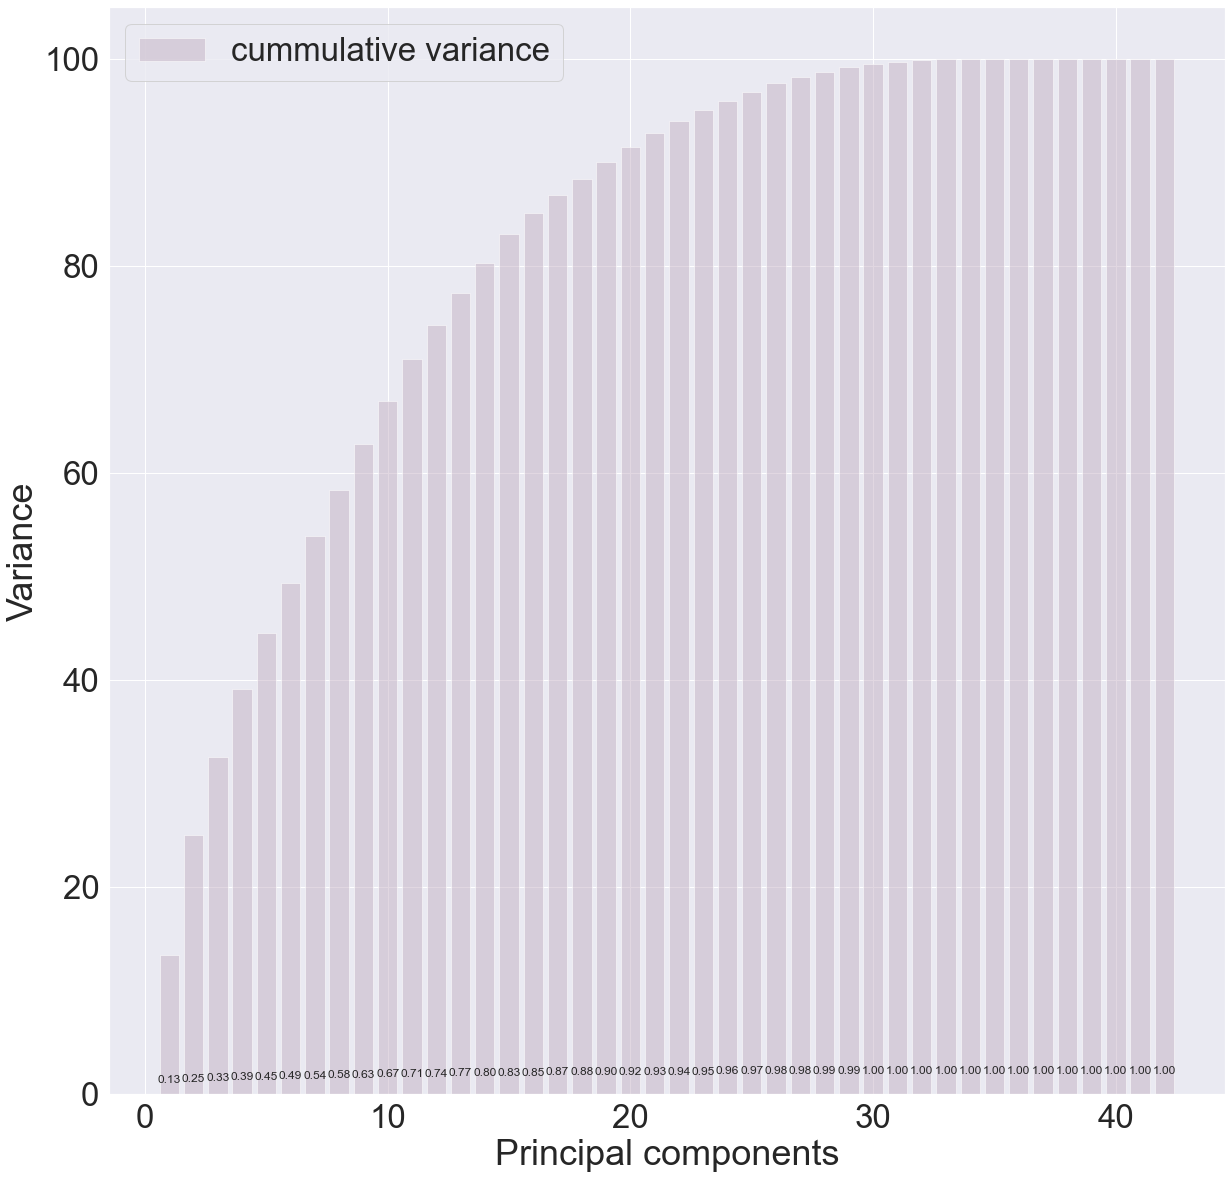

In [70]:
model = PCA()
model.fit_transform(X_train)
variance = model.explained_variance_
cum_var = np.cumsum(variance)/np.sum(variance)

plt.figure(figsize = (20,20))
plt.bar(range(1,43), cum_var*100, alpha = 0.5, align = 'center', label = 'cummulative variance', color = '#c4b1c4')
plt.legend()
plt.ylabel('Variance')
plt.xlabel('Principal components')

for x,y in zip(range(1,43),cum_var):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center'
                ,fontsize=12)
plt.show()

- From this graph we can see that by using 28 features 99% of the variance in the data is explained. So, we will reduce the number of features from 42 to 28.
- It worth mentioning that lowering the amount of features will not significantly lower the computability of the problem, but the advantage is in finding the best parameters for the models.

In [71]:
pca = PCA(n_components = 28)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train = np.array(X_train_pca)

y_train = np.array(y_train)
y_validation = np.array(y_validation)

In [72]:
X_train.shape

(71633, 28)

In [73]:
# applying the same PCA that was fitted by the train test.
def apply_pca(data, pca):   
    data = pca.transform(data)
    data = np.array(data)
    return data

In [74]:
X_validation = apply_pca(X_validation, pca)

In [75]:
X_validation.shape

(17909, 28)

In [76]:
y_validation.shape

(17909,)

# Test Data Pre-processing

- Applying the same pre-processing actions we made on the training set using the train set data values (as can be seen in the preprocessing_func()).

In [77]:
X_test = X_test.drop(['anon_feat_13', 'company','order_month'],axis=1) #dropping the same features we dropped from the train set earlier
X_test, y_temp = preprocessing_func(X_train_copy, X_test)

- Applying scaling and pca on the test set, using the models that was trained on the train set before.

In [78]:
X_test = apply_scaling(X_test, scaler)
X_test = apply_pca(X_test, pca)

In [79]:
X_test.shape

(29848, 28)

# Modeling

- For each model we will find the best hyper-parametes using GridSearchCV. For your convenience, we ran the GridSearch before and created the best hyper-parametes list from it's output (and commented out the GridSearch part).

### Logistic Regression

In [80]:
# lr_clf = LogisticRegression()
# param_grid = {'penalty': ['l1', 'l2'] ,
#               'C':[0.01,.09,1,5,10,25],
#               'solver':['lbfgs', 'liblinear'],
#               'max_iter' : [50,100,200],
#               'tol': [0.0001, 1e-4]
#              }
# # Create grid search object

# clf = GridSearchCV(estimator = lr_clf, param_grid = param_grid, scoring='roc_auc' ,cv = 3, verbose = 2, n_jobs=-1)
# clf.fit(X_train,y_train)
# clf.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


{'C': 0.01, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}

In [81]:
lgr_clf = LogisticRegression(
 C = 0.01,
 max_iter= 50,
 penalty= 'l2',
 solver= 'lbfgs',
 tol= 0.0001,
)
lgr_model = lgr_clf.fit(X_train, y_train)

In [82]:
fpr, tpr, thresholds = roc_curve(y_validation, lgr_model.predict_proba(X_validation)[:,1])
print('AUC score for Logistic Regression Test:', auc(fpr, tpr))

AUC score for Logistic Regression Test: 0.8507641215193572


### KNN

In [84]:
# knn_clf = KNeighborsClassifier()
# param_grid = {'n_neighbors': [20, 50, 70, 60] ,
#               'weights':['uniform', 'distance'],
#                'metric':['euclidean','manhattan']
#              }
# clf = GridSearchCV(knn_clf, param_grid = param_grid, scoring='roc_auc' ,cv = 3, verbose=True, n_jobs=-1)
# clf.fit(X_train,y_train)
# clf.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

In [85]:
knn_clf = KNeighborsClassifier(
     n_neighbors = 20,
     weights = 'distance',
    metric = 'manhattan'
)
knn_model = knn_clf.fit(X_train, y_train)

In [86]:
fpr, tpr, thresholds = roc_curve(y_validation, knn_model.predict_proba(X_validation)[:,1])
print('AUC score for KNN Test:', auc(fpr, tpr))

AUC score for KNN Test: 0.8964519555126217


### Decision Tree

In [83]:
# dt_clf = DecisionTreeClassifier()
# param_grid= {
#     'criterion':['gini','entropy'],
#     'max_depth':  [None],
#     'min_samples_split': [2, 4, 8],
#     'min_samples_leaf': [2, 3, 4]
# }
# clf = GridSearchCV(dt_clf, param_grid = param_grid, scoring='roc_auc' ,cv = 3, verbose=True, n_jobs=-1)
# clf.fit(X_train,y_train)
# clf.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [96]:
dt_clf = DecisionTreeClassifier(
 criterion =  'gini',
 max_depth = None,
 min_samples_leaf = 4,
 min_samples_split = 2
)
dt_model = dt_clf.fit(X_train, y_train)

In [97]:
fpr, tpr, thresholds = roc_curve(y_validation, dt_clf.predict_proba(X_validation)[:,1])
print('AUC score for Decision Tree Test:', auc(fpr, tpr))

AUC score for Decision Tree Test: 0.7971606025542333


### RandomForest

In [87]:
# rf_clf = RandomForestClassifier(random_state=6)
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [None],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [2, 3, 4],
#     'min_samples_split': [2, 4, 8],
#     'n_estimators': [150, 200, 250],
#     'criterion' :['gini','entropy']
#     }
# grid_search_rf = GridSearchCV(estimator= rf_clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 10)
# grid_search_rf.fit(X_train, y_train)
# grid_search_rf.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 250}

In [88]:
rf_clf = RandomForestClassifier(
 bootstrap= True,
 criterion='entropy',
 max_depth= None,
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split = 2,
 n_estimators = 250
)
rf_model = rf_clf.fit(X_train, y_train)

In [89]:
fpr, tpr, thresholds = roc_curve(y_validation, rf_model.predict_proba(X_validation)[:,1])
print('AUC score for Random Forest Test:', auc(fpr, tpr))

AUC score for Random Forest Test: 0.9074585078494576


# Model evaluation

In [90]:
def KfoldPlot(X, y, clf, k):
    clf_name = str(clf)[:str(clf).find("(")]
    kf  = KFold(n_splits = k)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    fig = plt.figure(figsize=[20,20])
    i = 1

    for train, test in kf.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i = i + 1

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

    mean_tpr = mean_tpr / k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (AUC = %0.4f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for {} model'.format(clf_name))
    plt.legend(loc="lower right")
    plt.show()

In [91]:
X = np.concatenate((X_train,X_validation))
y = np.concatenate((y_train,y_validation))

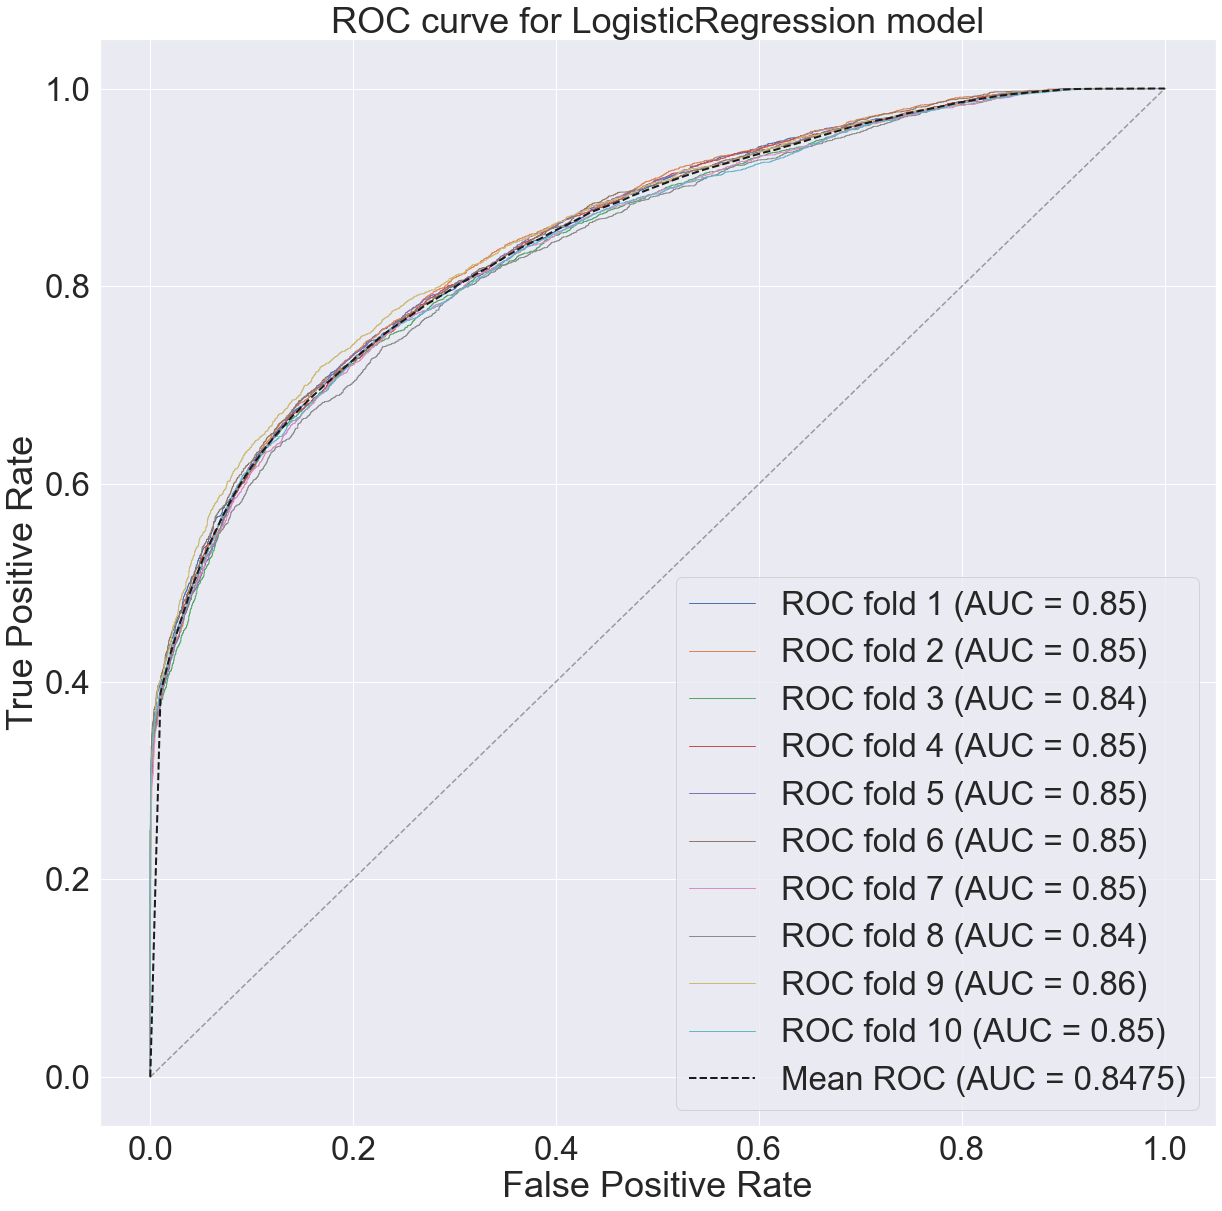

In [92]:
KfoldPlot(X, y, lgr_model, 10)

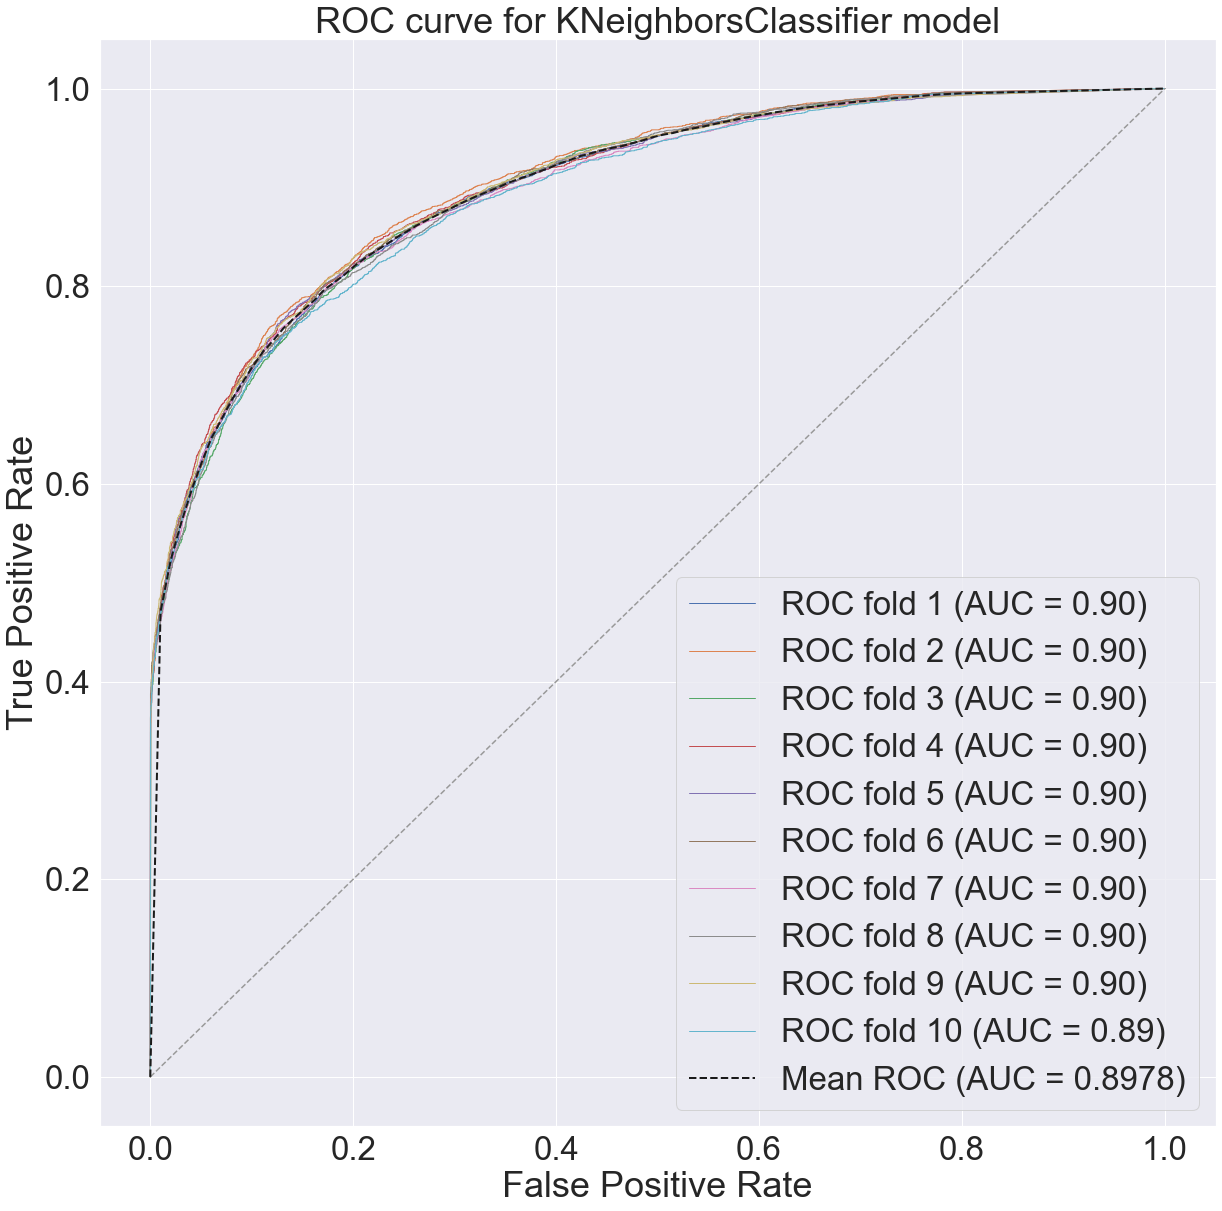

In [93]:
KfoldPlot(X, y, knn_model, 10)

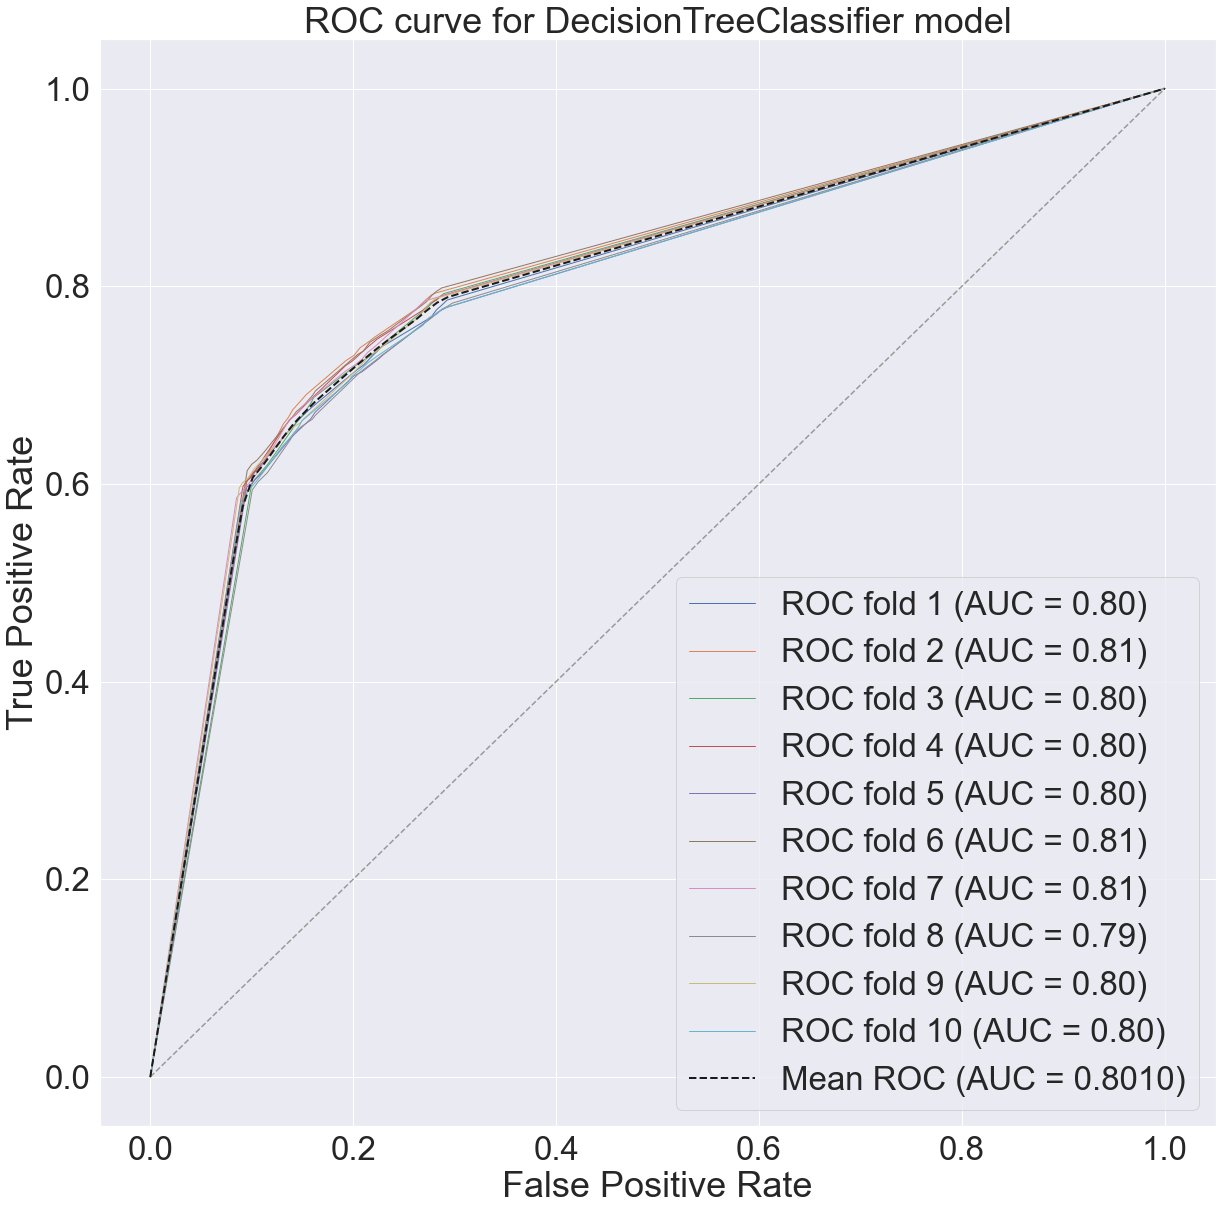

In [98]:
KfoldPlot(X, y, dt_model, 10)

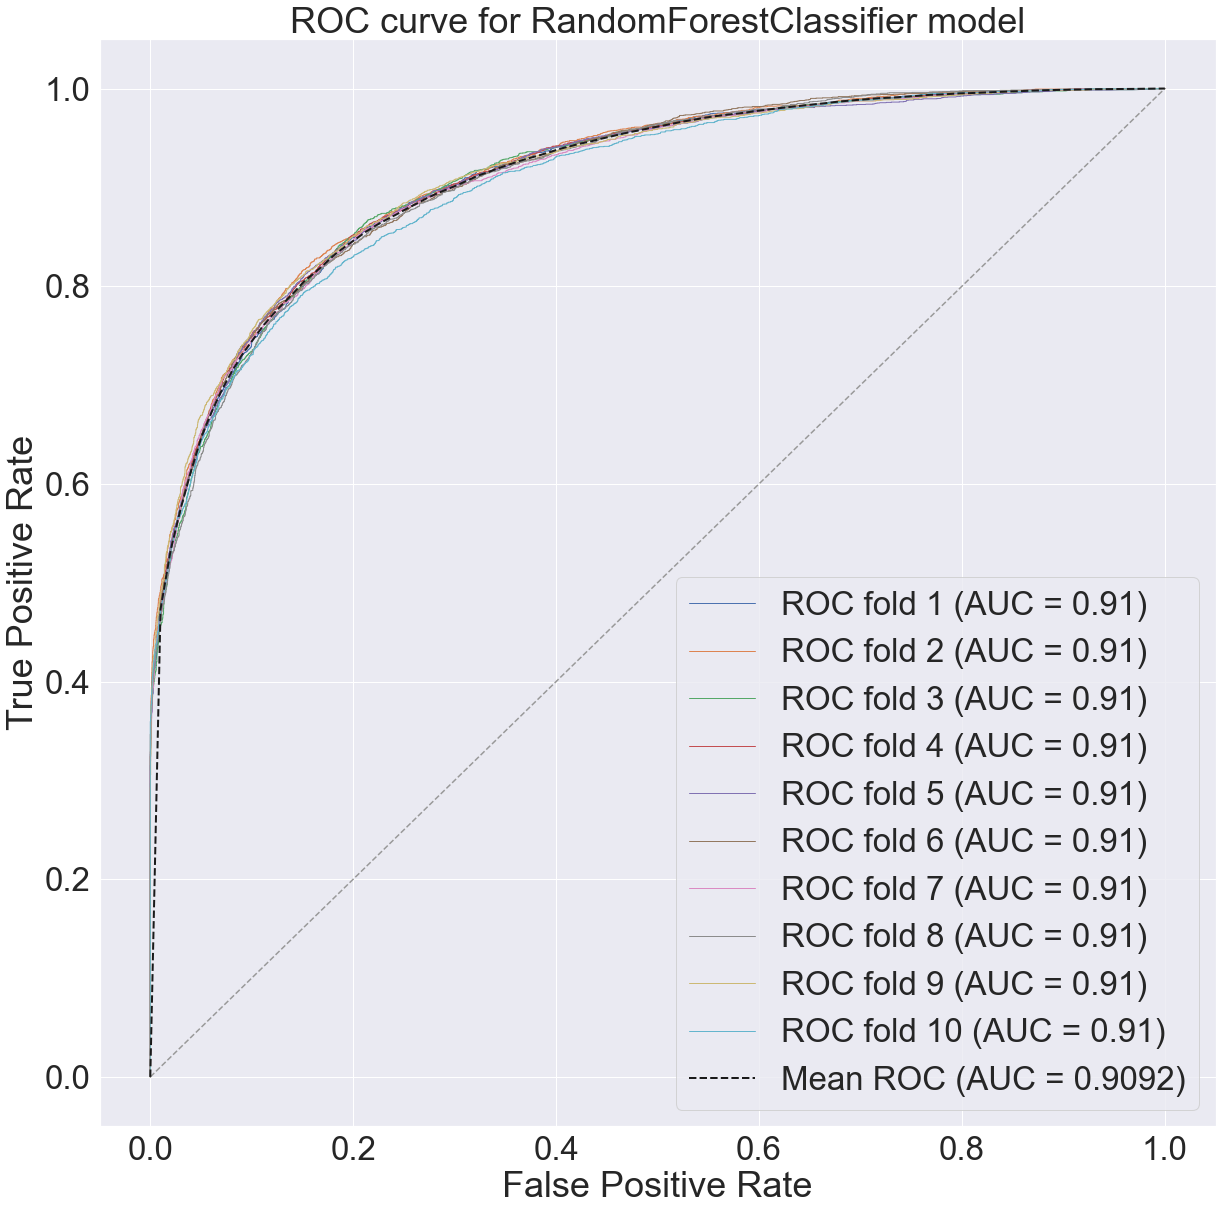

In [99]:
KfoldPlot(X, y, rf_model, 10)

- We can see that the Random Forest model has the best results, so we will chose it as the predictor model on the test data.

## Overfitting/Underfitting

- The gap between the AUC score on the prediction made with the validation set and the AUC score on the whole pre-processed data is very small. In addition, the AUC scores for each fold in th K-Fold cross validation, are very close and have little variance. Meaning our model is steady and changing the dataset doesn't affect it's perdictions. 
- From those reasones we can conclude our model is not overfitted nor underfitted. 

### Confusion matrix for the Random Forest Model

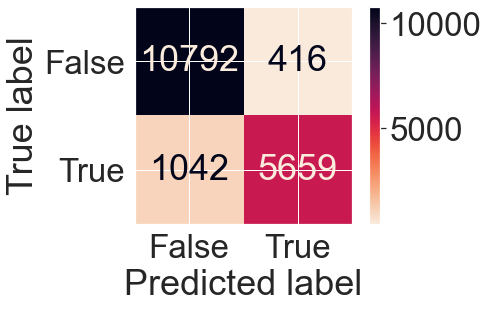

In [100]:
plot_confusion_matrix(rf_model,X_validation,y_validation,cmap='rocket_r')

- Out of those matrix cells we can compute the precision and the recall scores that can indicate on the model's prediction performance:

In [23]:
precision_score = 10792 / (10792 + 416) # TP / (TP + FP)
recall_score = 10792 / (10792 + 1042) # TP / (TP + FN)
print ("The precision score is", precision_score)
print("The recall score is", recall_score)

The precision score is 0.9628836545324768
The recall score is 0.9119486226128105


- The presicion score tells us that our prediction on a given sample is very good on most cases and we classify them correctly.
- As for the recall score, the model can be corrected, as for not little quantity of true cancelations, the model misses and label them as false. 

# Prediction on test data and Export

- Fitting the selected model with all the data.

In [102]:
rf_model.fit(X, y)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=250)

In [103]:
y_prob = rf_model.predict_proba(X_test)[:, 1]
df_predicted = pd.DataFrame({' ': X_test_Order_ID, 'cancel_proba': y_prob})
df_predicted = df_predicted.set_index(' ') #just to fit it to the submission tamplate
df_predicted.to_csv('Submission_19.csv',index = True, float_format='%.8f')